# Computer Vision - Assignment 2 - Deep Learning for Computer Vision

#### 10 points   |   Due date: November 26, 23:59   |   Submission site: https://pradogrado2324.ugr.es/

### Student's Full Name: <mark>JAVIER MORENO MORÓN</mark>

The goal of this assignment is to learn how to implement and use Convolutional Neural Networks using the fastai library (https://docs.fast.ai/).

<font color='blue'>The goal of this assignmnet is to gain experience designing and training deep neural networks (in particular, convolutional neural networks). From a base network architecture that is provided, you have to learn to perform experiments with it and to improve it by adding, modifying or deleting layers.

<font color='blue'>A help guide (`Assignment_2_HG.ipynb`) is also provided to know how:
1. Basic functions of reading data, training and optimization can be performed;
2. Graphs for the evolution of the classification error in
the training and validation sets can be created;
3. The classification error in the test set can be computed.

In [ ]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
!pip install -Uqq fastbook
!pip install nbdev
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.1/66.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 6.6 MB/s eta 0:00:00
Mounted at /content/gdrive
fastcore version 1.5.29 installed
fastai version 2.7.13 installed


In [ ]:
# Ajustamos semillas para poder reproducir los experimentos
from fastai.basics import set_seed

seed = 42  # Puedes usar cualquier número entero como semilla

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
set_seed(seed)


In [ ]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()



---



---



---



# <font color='blue'>**Exercise 1: BaseNet in CIFAR100 (3 points)**

<font color='blue'>*Dataset:*
In this exercise, we will work with part of the CIFAR100 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). This dataset consists of 60K color images of 32x32x3 (RGB) depicting 100 different classes (600 images per class). There are 50K images for training and 10K for testing. For the development of the exercise we will only consider 25 classes (out of 100). Therefore, the training set has 12,500 images and the test set 2,500 images. 10% of the training set will be used for validation.

<font color='blue'>**Model BaseNet:**
We start by creating a base model called *BaseNet* which, after its training and execution, will give us a classification error which will be used as reference or baseline for further improvements.

<font color='blue'>Our BaseNet model consists of two convolutional blocks (Conv+ReLU) at different scales (MaxPooling), and one head composed of two fully-connected (FC) layers (also called dense layers). The precise architecture is defined in the table below:

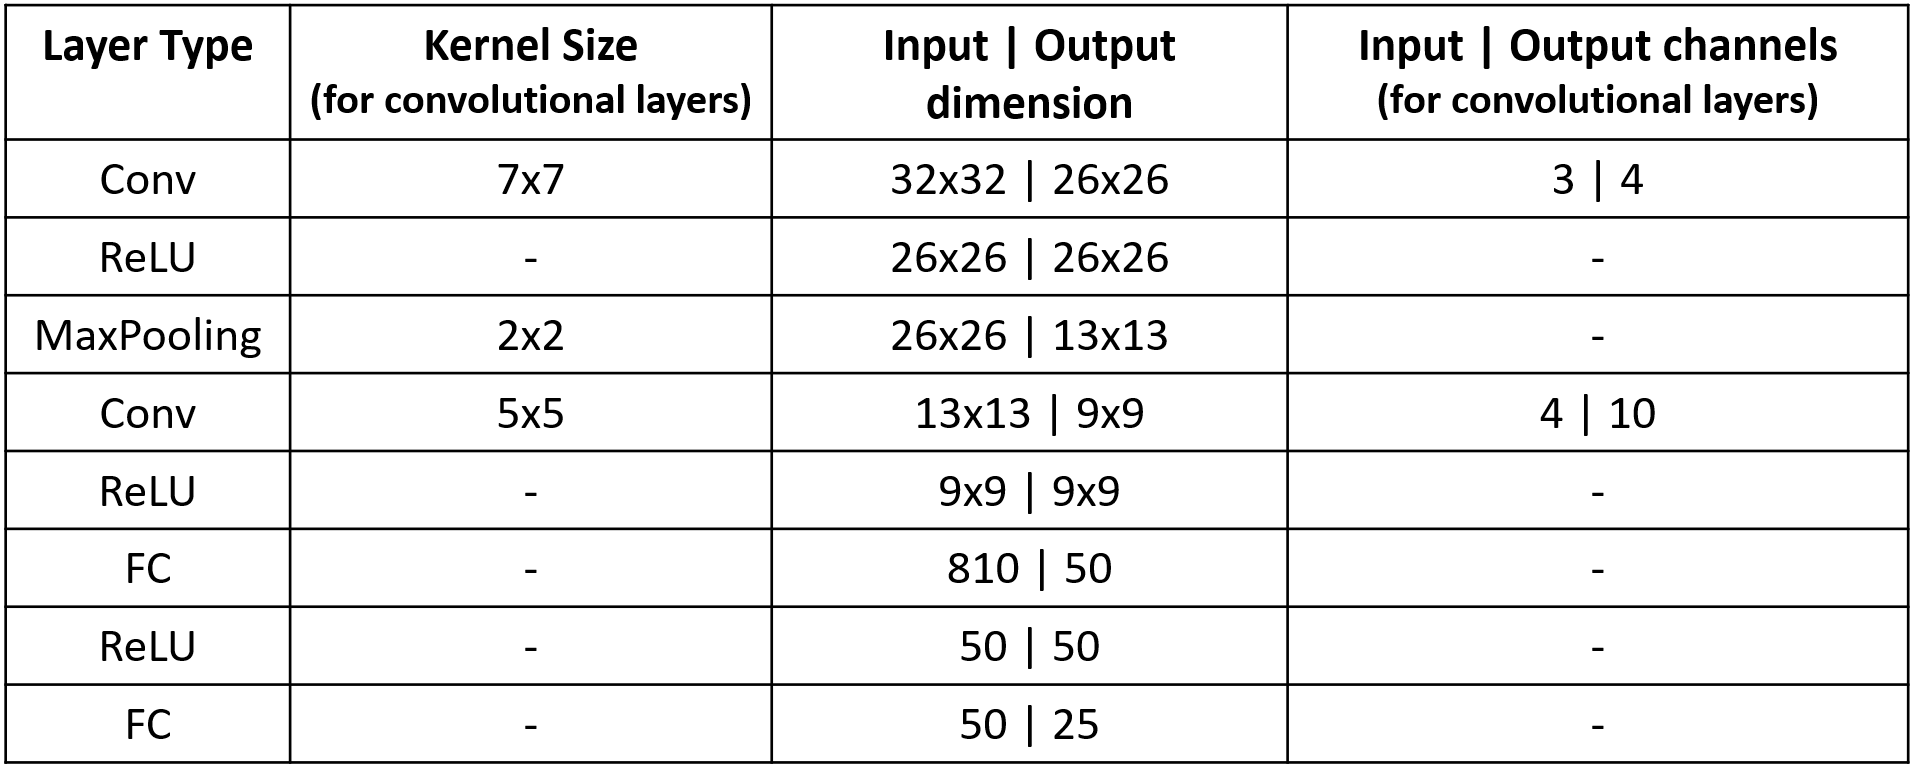


<font color='blue'>The students must:
1. Become familiar with the *BaseNet* architecture described above, the meaning of the different hyperparameters and the purpose of each layer. Create the code for the *BaseNet* model employing the fastai library.
2. Train the model (justifying all decisions made) and evaluate its performance. To do so, you should employ: the confusion matrix in training and testing; the accuracy in training, validation and test; and the evolution of both the loss function (in training and validation) and accuracy (in validation) with respect to the training epochs.

<font color='blue'>Note: This is the base model that we will try to improve in the next section. In this sense, it is not necessary to carry out a very sophisticated or complex training procedure. In any case, it is not advisable to use the default values of functions without having a justification for it. One must demonstrate that he/she understands what is doing, as well as what the framework does underneath.

In [ ]:
# We get the CIFAR100 dataset
path = untar_data(URLs.CIFAR_100,force_download=True)

Para obtener el conjunto de datos a usar en el problema usamos untar_data.

untar_data descarga automáticamente los datos desde la URL proporcionada y los almacena en la ubicación especificada (o la ubicación predeterminada). Luego, descomprime los datos si es necesario y devuelve una ruta a la ubicación donde se han almacenado los datos.

In [ ]:
# The CIFAR_100 dataset, as well as the MNIST dataset, follows a common layout for machine learning datasets:
# separate folders for the training set and the validation set (and/or test set).
# Let's see what's inside both the training and test sets
print(path)
print(sorted(path.ls()))
print(sorted((path/'train').ls()))
print(sorted((path/'test').ls()))
train_classes = sorted((path/'train').ls())
test_classes = sorted((path/'test').ls())
print(len(train_classes))

/root/.fastai/data/cifar100
[Path('/root/.fastai/data/cifar100/test'), Path('/root/.fastai/data/cifar100/train')]
[Path('/root/.fastai/data/cifar100/train/aquatic_mammals'), Path('/root/.fastai/data/cifar100/train/fish'), Path('/root/.fastai/data/cifar100/train/flowers'), Path('/root/.fastai/data/cifar100/train/food_containers'), Path('/root/.fastai/data/cifar100/train/fruit_and_vegetables'), Path('/root/.fastai/data/cifar100/train/household_electrical_devices'), Path('/root/.fastai/data/cifar100/train/household_furniture'), Path('/root/.fastai/data/cifar100/train/insects'), Path('/root/.fastai/data/cifar100/train/large_carnivores'), Path('/root/.fastai/data/cifar100/train/large_man-made_outdoor_things'), Path('/root/.fastai/data/cifar100/train/large_natural_outdoor_scenes'), Path('/root/.fastai/data/cifar100/train/large_omnivores_and_herbivores'), Path('/root/.fastai/data/cifar100/train/medium_mammals'), Path('/root/.fastai/data/cifar100/train/non-insect_invertebrates'), Path('/root/.

Ordenamos la salida de las rutas para quedarnos con las mismas clases siempre y poder repetir los experimentos.


"This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs)." https://github.com/fastai/dlcert2/blob/master/docs/datasets.md

In [ ]:
# We want to verify that within each of the 20 superclasses there are 5 classes,
# which gives the 100 classes there are. We also want to verify that the number of images is correct
print('Classes within the first superclass (',train_classes[0],'): ', train_classes[0].ls())
for i in range(20):
  print('Number of classes within superclass ',i,': ', len(train_classes[i].ls()))
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Classes within the first superclass ( /root/.fastai/data/cifar100/train/aquatic_mammals ):  [Path('/root/.fastai/data/cifar100/train/aquatic_mammals/whale'), Path('/root/.fastai/data/cifar100/train/aquatic_mammals/otter'), Path('/root/.fastai/data/cifar100/train/aquatic_mammals/beaver'), Path('/root/.fastai/data/cifar100/train/aquatic_mammals/dolphin'), Path('/root/.fastai/data/cifar100/train/aquatic_mammals/seal')]
Number of classes within superclass  0 :  5
Number of classes within superclass  1 :  5
Number of classes within superclass  2 :  5
Number of classes within superclass  3 :  5
Number of classes within superclass  4 :  5
Number of classes within superclass  5 :  5
Number of classes within superclass  6 :  5
Number of classes within superclass  7 :  5
Number of classes within superclass  8 :  5
Number of classes within superclass  9 :  5
Number of classes within superclass  10 :  5
Number of classes within superclass  11 :  5
Number of classes within superclass  12 :  5
Numbe

Podemos ver que en efecto cada superclase tiene 5 clases, así como que tanto el número de muestras de train como de test son correctos.

In [ ]:
# We keep the first 25 classes (we remove the last 75 from the dataset)
#https://stackoverflow.com/questions/185936/how-to-delete-the-contents-of-a-folder
import shutil
number_of_classes_to_keep = 25
number_of_superclasses_to_keep = int(number_of_classes_to_keep/5)
print('REMOVED SUPERCLASSES:')
for i in range(number_of_superclasses_to_keep,len(train_classes)):
  print(train_classes[i])
  shutil.rmtree(train_classes[i])
print('SUPERCLASSES WE KEEP:')
for i in range(number_of_superclasses_to_keep):
  print(train_classes[i])

REMOVED SUPERCLASSES:
/root/.fastai/data/cifar100/train/household_electrical_devices
/root/.fastai/data/cifar100/train/household_furniture
/root/.fastai/data/cifar100/train/insects
/root/.fastai/data/cifar100/train/large_carnivores
/root/.fastai/data/cifar100/train/large_man-made_outdoor_things
/root/.fastai/data/cifar100/train/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/train/large_omnivores_and_herbivores
/root/.fastai/data/cifar100/train/medium_mammals
/root/.fastai/data/cifar100/train/non-insect_invertebrates
/root/.fastai/data/cifar100/train/people
/root/.fastai/data/cifar100/train/reptiles
/root/.fastai/data/cifar100/train/small_mammals
/root/.fastai/data/cifar100/train/trees
/root/.fastai/data/cifar100/train/vehicles_1
/root/.fastai/data/cifar100/train/vehicles_2
SUPERCLASSES WE KEEP:
/root/.fastai/data/cifar100/train/aquatic_mammals
/root/.fastai/data/cifar100/train/fish
/root/.fastai/data/cifar100/train/flowers
/root/.fastai/data/cifar100/train/food_containers
/ro

In [ ]:
# We also remove the classes from the test set
for i in range(number_of_superclasses_to_keep,len(test_classes)):
  print(test_classes[i])
  shutil.rmtree(test_classes[i])

/root/.fastai/data/cifar100/test/household_electrical_devices
/root/.fastai/data/cifar100/test/household_furniture
/root/.fastai/data/cifar100/test/insects
/root/.fastai/data/cifar100/test/large_carnivores
/root/.fastai/data/cifar100/test/large_man-made_outdoor_things
/root/.fastai/data/cifar100/test/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/test/large_omnivores_and_herbivores
/root/.fastai/data/cifar100/test/medium_mammals
/root/.fastai/data/cifar100/test/non-insect_invertebrates
/root/.fastai/data/cifar100/test/people
/root/.fastai/data/cifar100/test/reptiles
/root/.fastai/data/cifar100/test/small_mammals
/root/.fastai/data/cifar100/test/trees
/root/.fastai/data/cifar100/test/vehicles_1
/root/.fastai/data/cifar100/test/vehicles_2


In [ ]:
# Now we check if we have remove them correctly
print(path)
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))
print(len(test_classes))

/root/.fastai/data/cifar100
5
5


Ahora ya tenemos el número de clases deseado, 25.

In [ ]:
# And that the number of examples in training and test is correct
print('Classes within the first superclass (',train_classes[0],'): ', train_classes[0].ls())
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Classes within the first superclass ( /root/.fastai/data/cifar100/train/food_containers ):  [Path('/root/.fastai/data/cifar100/train/food_containers/bottle'), Path('/root/.fastai/data/cifar100/train/food_containers/bowl'), Path('/root/.fastai/data/cifar100/train/food_containers/can'), Path('/root/.fastai/data/cifar100/train/food_containers/plate'), Path('/root/.fastai/data/cifar100/train/food_containers/cup')]
Total training images:  12500
Total test images:  2500


Podemos ver que la primera superclase es sobre mamíferos acuáticos, aquatic_mammals, y que las clases que contiene son whale, otter, beaver, seal y dolphin.

Vemos también que la cantidad de datos para train y test sigue siendo correcta.

In [ ]:
# Ver dimensión de las imágenes
# Comentado, ya que la ruta deja de ser util cada vez que se actualiza la base de datos
print(files_train)

import cv2

# Cargar la imagen con OpenCV
imagen = cv2.imread('/root/.fastai/data/cifar100/train/aquatic_mammals/whale/whale_s_000513.png')

# Obtener las dimensiones de la matriz
alto, ancho, canales = imagen.shape

# Imprimir las dimensiones
print(f"Alto de la imagen: {alto} píxeles")
print(f"Ancho de la imagen: {ancho} píxeles")
print(f"Número de canales: {canales}")


[Path('/root/.fastai/data/cifar100/train/food_containers/bottle/pop_bottle_s_000830.png'), Path('/root/.fastai/data/cifar100/train/food_containers/bottle/bottle_s_001458.png'), Path('/root/.fastai/data/cifar100/train/food_containers/bottle/ketchup_bottle_s_000458.png'), Path('/root/.fastai/data/cifar100/train/food_containers/bottle/beer_bottle_s_000278.png'), Path('/root/.fastai/data/cifar100/train/food_containers/bottle/beer_bottle_s_002094.png'), Path('/root/.fastai/data/cifar100/train/food_containers/bottle/soda_bottle_s_000113.png'), Path('/root/.fastai/data/cifar100/train/food_containers/bottle/beer_bottle_s_000998.png'), Path('/root/.fastai/data/cifar100/train/food_containers/bottle/bottle_s_000439.png'), Path('/root/.fastai/data/cifar100/train/food_containers/bottle/beer_bottle_s_000028.png'), Path('/root/.fastai/data/cifar100/train/food_containers/bottle/beer_bottle_s_000926.png'), Path('/root/.fastai/data/cifar100/train/food_containers/bottle/pop_bottle_s_000186.png'), Path('/

Vemos las dimensiones de las imágenes del dataset. Estas son 32x32.

### DataBlock

Ahora el primer paso es cargar los datos y preprocesarlos, usamos para ello DataBlock y DataLoaders.

DataBlock se utiliza para definir las transformaciones de datos y cómo se deben dividir en conjuntos de entrenamiento y validación. Alguno de los parámetros que podemos modificar para especificar las tareas que debe realizar DataBlock son:
* blocks: Este parámetro es una lista de objetos que representan los tipos de datos que se encuentran en tus datos. Por ejemplo, si estás trabajando con imágenes y etiquetas de texto, blocks podría ser [ImageBlock, TextBlock]. Esto especifica qué bloques de transformación se aplicarán a cada tipo de dato. En nuestro caso como las entradas son imágenes usaremos ImageBlock y como la salida son categorías como bus o motorcycle usaremos CategoryBlock.

* get_items: Esta función se utiliza para obtener una lista de elementos de tus datos. Por ejemplo, si estás trabajando con imágenes, get_items podría ser una función que devuelve una lista de rutas de archivo a las imágenes. En nuestro caso usaremos la función proporcionada por fastai get_image_files(path, recurse, folders), la cual obtiene las imagenes de la ruta (path) especificada recursivamente si se activa y solo de los folders especificados.

* splitter: Esta función se utiliza para dividir los datos en conjuntos de entrenamiento y validación. Puede ser una función o un valor entero que determina la división de datos. Una opción puede ser usar la función de fastai GrandparentSplitter(train_name, valid_name), que divide en train y validación según el nombre del directorio abuelo de las imágenes, el cual debe coincidir con el valor especificado. En nuestro caso como tenemos una estructura de superclases donde el directorio abuelo es el nombre de la propia superclase aparte de que todas las imágenes están en el directorio bisabuelo train usaremos otra función, esta es RandomSplitter(valid_pct, seed), que separa el porcentaje especificado para validación de forma aleatoria.

* get_x y get_y: Estas funciones se utilizan para obtener los datos de entrada (x) y las etiquetas (y) de tus datos. En nuestro caso ya hemos especificado como obtener las imágenes, así que solo usaremos get_y, por la estructura de los datos las etiquetas son el nombre del directorio padre donde se encuentran las imágenes, por lo que usamos la función de fastai parent_label().

* item_tfms: Aquí puedes especificar las transformaciones que se aplicarán a cada elemento de datos individual. Esto puede incluir redimensionar imágenes, normalizar valores numéricos, tokenizar texto, entre otros. En nuestro caso no lo usaremos, ya que las imágenes ya están en tamaño 32x32, que es el tamaño inicial con el que entrarán en la red.

* batch_tfms: Estas transformaciones se aplican a los lotes de datos, es decir, a un conjunto de elementos de datos a la vez. Puedes usar esto para realizar transformaciones como la normalización. En modelos ya preentrenados, no es necesario normalizar, ya que es el propio modelo el que lo hace ya automáticamente, pero como no es el caso aquí normalizaremos usando Normalize(), que calcula la media y desviación típica en cada píxel de los datos del problema para luego a cada imagen restarle la media y dividir por la desviación típica en cada píxel.

In [ ]:
#https://docs.fast.ai/data.transforms.html#normalize

dbk = DataBlock(
                blocks = (ImageBlock, CategoryBlock),
                get_items = get_image_files,
                splitter = RandomSplitter(valid_pct=0.1, seed=0), # 10% validación como dice el guión
                get_y = parent_label,
                batch_tfms = Normalize()
)

dbk.summary(path/'train')

Setting-up type transforms pipelines
Found 12500 items
2 datasets of sizes 11250,1250
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/cifar100/train/food_containers/bottle/beer_bottle_s_000165.png
    applying PILBase.create gives
      PILImage mode=RGB size=32x32
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/cifar100/train/food_containers/bottle/beer_bottle_s_000165.png
    applying parent_label gives
      bottle
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(3)

Final sample: (PILImage mode=RGB size=32x32, TensorCategory(3))


Found 12500 items
2 datasets of sizes 11250,1250
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': 

Usamos la función de DataBlock summary(), para ver las transformaciones y pasos que se realizan para un batch.

Creamos el dataset de entrenamiento con dataloaders(), esta función toma como argumento un DataBlock y una ubicación o fuente de datos (por ejemplo, un directorio con imágenes) y crea los objetos DataLoaders configurados de acuerdo con la definición del DataBlock. Esto incluye cargar y transformar los datos según las especificaciones proporcionadas en el DataBlock.

En nuestro caso también especificamos que los batch sean de tamaño 32 frente a 64 que es como viene ajustado de forma predeterminada. Un tamaño de batch menor puede ser beneficioso para evitar agotar la memoria del backend de colab a la hora de entrenar el modelo, aunque el tiempo de cómputo será mayor.

También tener un batch menor introduce más variabilidad estocástica en cada actualización de pesos, lo que puede actuar como una forma de regularización estocástica, ayudando a prevenir el sobreajuste.

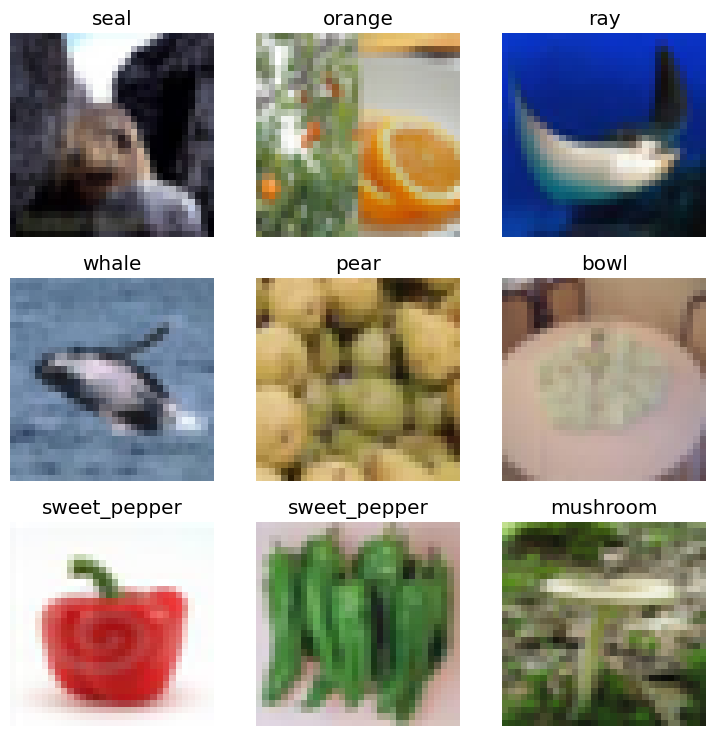

In [ ]:
dls = dbk.dataloaders(path/'train', bs=32)

dls.show_batch() # Muestra un conjunto de imágenes

### Red Neuronal

Creamos ahora el que será el modelo de aprendizaje.

Para ello como lo que queremos es crearlo de cero y no usar uno existente lo creamos con Sequential(), que creará un modelo secuencial. Un modelo secuencial es un tipo de arquitectura de red neuronal en la que las capas se organizan de manera secuencial, una después de la otra, y la información fluye de una capa a la siguiente en una única dirección, generalmente desde la entrada hasta la salida.

Algunas de las opciones que puedes usar para configurar las capas de la red neuronal son:
* Capas de redes neuronales: Puedes proporcionar capas de redes neuronales como nn.Linear, nn.Conv2d, nn.RNN, nn.LSTM, nn.GRU, entre otras. Estas capas realizan operaciones específicas en tus datos, como operaciones lineales, convoluciones, activaciones, etc.

* Funciones de activación: Las funciones de activación como nn.ReLU, nn.Sigmoid, nn.Tanh también se pueden pasar como argumentos. Estas funciones se utilizan para introducir no linealidad en el modelo.

* Capas de pooling: Las capas de pooling, como nn.MaxPool2d o nn.AvgPool2d, que se utilizan para reducir la resolución espacial de las características.

* Capas de normalización: Capas de normalización como nn.BatchNorm2d para la normalización de batches o nn.LayerNorm para la normalización por capas.

---

Las funciones que usaremos para esta primera red base serán los siguientes:
* Conv2d: Esta capa aplica convoluciones en 2D a los datos de entrada y es fundamental en la extracción de características en problemas de visión por computadora. Los parámetros de esta función son los siguientes:

  * in_channels: Número de canales en la entrada. Por ejemplo, en imágenes a color RGB, in_channels generalmente es 3.

  * out_channels: Número de canales de salida, es decir, el número de filtros que se aplicarán a la entrada. Cada filtro captura una característica diferente en los datos. Cuanto mayor sea out_channels, más características se extraerán.

  * kernel_size: Tamaño del filtro o kernel utilizado en la convolución. Puede ser un entero (para filtros cuadrados) o una tupla de dos enteros (para filtros rectangulares).

  * stride: Tamaño del paso que el filtro toma al desplazarse sobre los datos de entrada. Determina cuántos píxeles se mueve el filtro en la dirección horizontal y vertical después de cada operación de convolución. Puede ser un entero o una tupla de dos enteros.

  * padding: Controla el relleno de ceros alrededor de los datos de entrada antes de aplicar la convolución. Puede ser "valid" (sin relleno) o "same" (relleno para mantener el tamaño). También se puede especificar un valor entero o una tupla de dos enteros para un relleno personalizado.

  * dilation: Controla el espaciado entre los elementos del kernel. Un valor mayor que 1 indica que se saltearán algunos píxeles durante la convolución. Puede ser un entero o una tupla de dos enteros. https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md (Visualización del efecto de aplicar dilation)

  * groups: Divide la entrada en grupos para aplicar convoluciones separadas. Esto es útil en modelos de redes neuronales avanzados, como redes convolucionales separables en profundidad.

  * bias: Un booleano que especifica si se debe incluir un término de sesgo (bias) en la convolución.

  * padding_mode: Controla el tipo de relleno en caso de que padding se establezca en un valor entero. Puede ser "zeros" (relleno con ceros) o "reflect" (relleno reflejado).

* ReLU: Es una capa de activación que se utiliza comúnmente en las redes neuronales como una función de activación no lineal. "ReLU" significa "Rectified Linear Unit", y es una función matemática simple pero efectiva que introduce no linealidad en el modelo.

* MaxPool2d: Es una capa de pooling que se utiliza comúnmente en redes neuronales convolucionales (CNNs) para reducir la resolución espacial de las características y disminuir la cantidad de datos en capas intermedias de la red. Comparte algunos parámetros con Conv2d, como kernel_size, stride, padding o dilation.

* Flatten: La operación Flatten() transforma una matriz multidimensional en un vector unidimensional. Esto es útil cuando se pasa de las capas convolucionales a las capas completamente conectadas en una red neuronal, ya que las capas completamente conectadas requieren una entrada unidimensional.

* Linear: Realiza una transformación lineal de los datos de entrada. Esta capa se utiliza comúnmente en las redes neuronales completamente conectadas (también conocidas como redes neuronales feedforward) para introducir relaciones lineales entre las características de entrada. La operación realizada por nn.Linear() es esencialmente una multiplicación de matriz entre los datos de entrada y una matriz de pesos, seguida de la adición de un vector de sesgos. Sus parámetros principales son:

  * in_features: Este parámetro especifica el número de características (neuronas) en la entrada de la capa. Debe ser un entero que indique las dimensiones de la entrada.

  * out_features: Indica el número de características (neuronas) en la salida de la capa. Debe ser un entero que determina las dimensiones de la salida.

  * bias: Un valor booleano que controla si se deben incluir los sesgos en la capa. Si se establece en True, se incluirán sesgos; si se establece en False, no se incluirán.

---
Aparte de esas funciones, otra función bastante común de usar es Softmax(), la razón de que no la usemos aquí es porque este es un problema de clasificación donde probablemente especifique como función de pérdida la entropía cruzada, al especificarla el propio pytorch aplica una capa de Softmax, por lo que no es necesaria aplicarla manualmente.

* Softmax: Es una función de activación utilizada comúnmente en la capa de salida de una red neuronal para convertir las salidas en valores de probabilidad. Es especialmente útil en problemas de clasificación multiclase, donde se debe asignar una de varias clases posibles a una entrada.

In [ ]:
from torch import nn

simpleNet = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=4, kernel_size=7), # kernel 7, pasa dimensión de 32x32 a 26x26
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2), # Dimensionalidad 26x26 --> 13x13
    nn.Conv2d(in_channels=4, out_channels=10, kernel_size=5), # 13x13 --> 9x9
    nn.ReLU(),
    nn.Flatten(), # 9x9 --> 810(dimensión * núm. canales)
    nn.Linear(in_features=810, out_features=50), # 810 --> 50
    nn.ReLU(),
    nn.Linear(in_features=50, out_features=25)
)

total_params(simpleNet)

(43427, True)

Ahora pasamos a declarar el learner, que será el objeto que realmente realizará el aprendizaje en base al modelo de NN creado en la celda anterior, para esta tarea usamos la clase Learner de fastai.

El constructor de esta clase puede ser generado con las siguientes opciones o argumentos:
* dls: El objeto DataLoaders que contiene los datos de entrenamiento y validación. Es esencial proporcionar los datos para entrenar y evaluar el modelo.

* model: El modelo de la red neuronal que deseas entrenar. Puede ser una arquitectura preentrenada, una red personalizada o un modelo predefinido de Fastai. En nuestro caso la red personalizada que acabamos de crear.

* loss_func: La función de pérdida que se utilizará para calcular la pérdida durante el entrenamiento. En nuestro caso como se trata de un problema de clasificación usaremos la CrossEntropyLoss.
  * Usaré CrossEntropyLossFlat(), la principal diferencia entre CrossEntropyLoss y CrossEntropyLossFlat radica en cómo se manejan las etiquetas de clases. CrossEntropyLoss espera etiquetas en formato "one-hot encoding", mientras que CrossEntropyLossFlat permite etiquetas en formato entero y se encarga de la conversión internamente, que en este caso es más conveniente.

* opt_func: El optimizador que se utilizará para ajustar los pesos del modelo durante el entrenamiento. Puedes elegir entre optimizadores como Adam, SGD, RMSprop, entre otros. Usaré Adam, ya que es el mejor en la mayoría de casos y no es tan dependiente del learning rate como lo puede ser SGD.

* metrics: Una lista de métricas que se utilizarán para evaluar el rendimiento del modelo durante el entrenamiento. Por ejemplo, precisión (accuracy), F1-score, etc. En principio usaré solo la Accuracy ya que es un modelo base y estoy un poco haciendome al entorno y no resolviendo un problema real, decir que en casos reales es importante usar varias métricas, ya que usar solo una puede ser engañoso y no enseñar los desempeños totales del modelo.

* cbs: Callbacks (retroalimentaciones) personalizados que se utilizarán para controlar y personalizar el proceso de entrenamiento. Los callbacks son funciones que se ejecutan en momentos específicos durante el entrenamiento.

* wd: La regularización L2 (peso de decaimiento) que se aplicará durante el entrenamiento.

In [ ]:
from fastai.learner import Learner

learn = Learner(dls=dls, model=simpleNet, loss_func=CrossEntropyLossFlat(), opt_func=Adam, metrics=accuracy)

Ahora que ya tenemos el modelo y la red neuronal creados y configurados pasamos a entrenarlo, para ello seguiremos una serie de pasos:

Primero toca elegir el valor del learning rate, para ello usamos la función lr_find() de Learner, lo que hace dicha función es entrenar el modelo durante un pequeño número de épocas mientras aumenta gradualmente la tasa de aprendizaje desde un valor muy pequeño. Esto se hace para explorar cómo cambia la pérdida a medida que la tasa de aprendizaje varía.

Durante el entrenamiento, lr_find() registra la pérdida en cada paso a medida que aumenta la tasa de aprendizaje.

Luego, el método genera un gráfico que muestra cómo cambia la pérdida a medida que varía la tasa de aprendizaje. El gráfico suele ser una representación en forma de U, y el objetivo es encontrar el punto en el que la pérdida es más baja antes de que comience a aumentar nuevamente.

SuggestedLRs(valley=0.0014454397605732083)


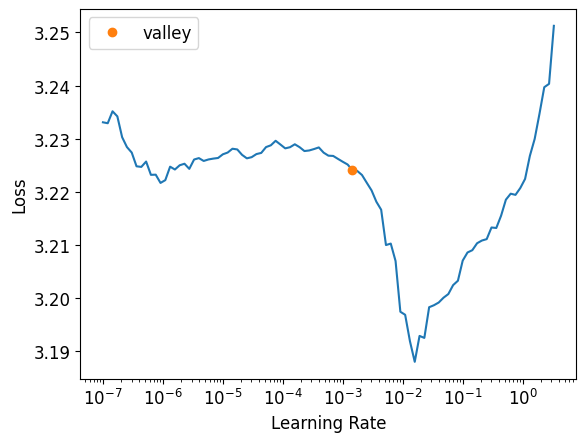

In [ ]:
# Realizar una búsqueda de tasa de aprendizaje
lr = learn.lr_find()

print(lr)

Tras calcular el lr óptimo para el problema pasamos ya al entrenamiento en sí, para entrenar existen dos funciones, fit_one_cycle() y fit(), la principal diferencia entre ambos modelos es que mientras fit() es el método de entrenamiento estándar en Fastai y se utiliza para entrenar modelos de manera más tradicional, donde la tasa de aprendizaje generalmente se establece con un valor fijo, usar fit_one_cycle() implica el uso de tasas de aprendizaje que aumentan gradualmente al comienzo del entrenamiento, alcanzan un valor máximo y luego disminuyen gradualmente hacia el final del entrenamiento. El proposito de este método es acelerar el entrenamiento al principio para escapar de los mínimos locales y luego reducir la tasa de aprendizaje para obtener una convergencia más precisa al final.

En nuestro caso usaremos este segundo método, por la ventaja de que va actualizando el lr de la manera más conveniente en la mayoría de casos.

fit_one_cycle() tiene varios parámetros que se pueden modificar, estos son:
* n_epoch: El número de épocas (ciclos completos a través del conjunto de datos de entrenamiento) que deseas entrenar el modelo. Por lo general a más mejor, hasta que no salga rentable por lo poco que mejora y por el tiempo de ejecución invertido, este parámetro hay que especificarlo obligatoriamente, lo pondré a 10 y valoraré los resultados.

* lr_max: La tasa de aprendizaje máxima en el ciclo. Es el valor máximo que alcanzará la tasa de aprendizaje durante el entrenamiento. Usaremos el valor de lr ya obtenido como óptimo.

* div: El factor por el cual se divide lr_max para determinar la tasa de aprendizaje inicial. Por defecto, es 25, este parámetro se puede ajustar probando varios valores y seleccionando el que mejores resultados dé, en este caso como es un modelo base para aprender como funciona la librería no haré ese proceso de selección.

* div_final: El factor por el cual se divide lr_max para determinar la tasa de aprendizaje al final del ciclo. Por defecto, es 1e5. Mismo caso que div para determinar su valor.

* pct_start: La fracción del ciclo durante la cual la tasa de aprendizaje aumentará. Por defecto, es 0.25, lo que significa que el 25% del ciclo se utilizará para aumentar la tasa de aprendizaje.

* wd: El valor del decaimiento de peso (weight decay) que se aplicará durante el entrenamiento. Controla la regularización L2 de los pesos del modelo. Por defecto, es None.

* moms: Un par de valores que controla la programación del momentum, este es una técnica que se utiliza para acelerar la convergencia del entrenamiento y mejorar la estabilidad del proceso. Este es su procedimiento:
  * En cada paso de optimización, se calcula un promedio ponderado de los gradientes anteriores y se acumula en una variable llamada "momentum". Este promedio ponderado es similar a la inercia en la física.

  * En lugar de actualizar los pesos directamente con el gradiente actual, se utiliza el valor acumulado en la variable de momentum para influir en la dirección y la velocidad de la actualización de los pesos.

  * El momentum ayuda a suavizar el proceso de actualización de los pesos, lo que puede ayudar a superar problemas como mínimos locales y oscilaciones en la función de pérdida. Esto conduce a una convergencia más rápida y estable.

  * El valor del momentum suele estar en el rango de [0, 1], y valores comunes son 0.9 o 0.99. Un valor más alto dará más peso a los gradientes anteriores, lo que suavizará aún más el proceso de actualización.

  Por defecto, es None.

* cbs: Callbacks personalizados que se utilizarán durante el entrenamiento. Los callbacks son funciones que se ejecutan en momentos específicos durante el entrenamiento y permiten personalizar el proceso.

* reset_opt: Un valor booleano que controla si se restablecerá el optimizador antes de iniciar el entrenamiento. Por defecto, es False, lo que significa que el optimizador no se reiniciará. Como vamos a hacer un entrenamiento de cero lo dejamos a True.

* start_epoch: El número de la primera época. Por defecto, es 0.

epoch,train_loss,valid_loss,accuracy,time
0,2.701569,2.646618,0.180800,00:19
1,2.389271,2.394928,0.258400,00:22
2,2.284632,2.259541,0.299200,00:16
3,2.177750,2.167983,0.324000,00:16
4,2.085093,2.124607,0.354400,00:16
5,1.995585,2.087621,0.362400,00:17
6,1.900980,2.060526,0.364800,00:16
7,1.827677,2.033921,0.378400,00:15
8,1.799096,2.022227,0.390400,00:15
9,1.748069,2.018001,0.386400,00:15


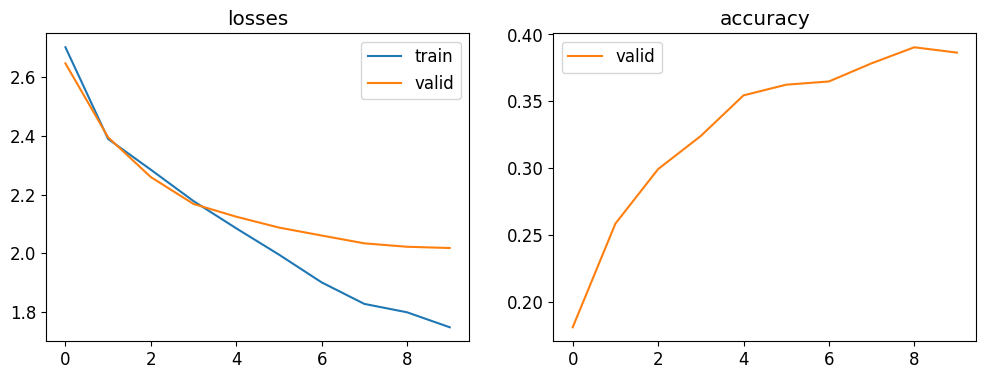

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 4 x 26 x 26    
Conv2d                                    592        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 4 x 13 x 13    
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 10 x 9 x 9     
Conv2d                                    1010       True      
ReLU                                                           
____________________________________________________________________________
                     32 x 810            
Flatten                                                        
____________________________________________________________________________
                     32 x 50     

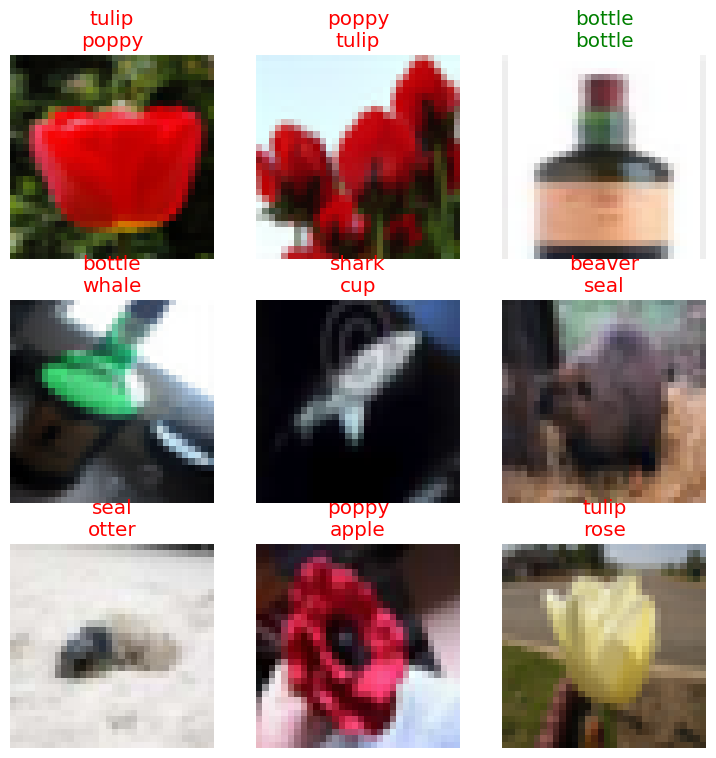

In [ ]:
learn.fit_one_cycle(n_epoch=10, lr_max=lr[0], reset_opt=True)
learn.recorder.plot_metrics() # muestra la gráfica de la accuracy
learn.show_results()
learn.summary() # resumen del entrenamiento

Tras realizar el entrenamiento pedimos al modelo que imprima varias cosas, vamos por orden.

Lo primero que nos aparece es una tabla con información de que valores toman tanto la accuracy como la función de pérdida tanto en train como en validación por cada época de entrenamiento, esta tabla se va imprimiendo según el modelo va entrenando y la principal conclusión que se puede sacar de ella es que apartir de la cuarta época la mejora del modelo se estanca, en parte probablemente porque por la política de actualización del learning rate este sea más pequeño ya y las actualizaciones lleguen en saltos más pequeños, y en parte porque al ser un modelo muy básico esto sea el máximo que puede dar.

De todas formas en cuanto a sacar conclusiones, usando la función plot_metrics() podemos ver las gráficas de como van cambiando los valores de la accuracy y la función de pérdida, observando dichas gráficas podemos por un lado confirmar como la mejora en la accuracy va estancandose y por otro lado como el modelo va cada vez sobreajustandose más, esto es normal al no haber aplicado regularización al entrenamiento. También en la gráfica de pérdida se observa ese estancamiento en validación, que corresponde al estancamiento que ya he comentado de accuracy.

Después de las gráficas se muestra un resumen de la red neuronal, este puede ser útil para comprobar por ejemplo que esta ha sido creada correctamente o que las dimensiones de los inputs y outputs son correctas, este resumen se muestra llamando a la función summary(). Podemos observar también en el resumen que hay varios callbacks incluidos de forma predeterminada, estos son:
* TrainEvalCallback: Este es un callback que se utiliza para llevar un registro de las métricas de entrenamiento y evaluación durante el proceso de entrenamiento.

* CastToTensor: Es un callback que se utiliza para garantizar que los datos de entrada se conviertan en tensores de PyTorch antes de ser procesados por el modelo.

* Recorder: Que es un callback que se utiliza para registrar información relacionada con el entrenamiento, como la pérdida y las métricas.

* ProgressCallback: Es un callback que se utiliza para mostrar información sobre el progreso del entrenamiento en la consola. La tabla que vemos seguramente.

Y por último vemos varias imágenes que han sido etiquetadas correcta o incorrectamente, para ver como funciona el modelo para casos reales, esto no nos dice mucho porque al final son 9 fotos nada más, pero vemos que se aciertan 3 de 9 que es algo más de un 36% de accuracy, es decir que el resultado es lógico. La función usada para mostrar estos resultados es show_results().

Tras ver un poco un resumen básico de los resultados del modelo, vamos a ver cual es el valor final de la accuracy tanto en train como en validación, para ver un poco como generaliza el modelo, que ya preveemos que mal por lo visto con la función de pérdida.

Para ello primero usamos la función get_preds() para obtener las predicciones del modelo tanto para el conjunto de entrenamiento como para el de validación, a la función se le pasa el DataLoader del cual deseas obtener las predicciones y opcionalmente otros argumentos como el que pasamos en nuestro caso, que lo que hace es devolver las etiquetas decodificadas. Las etiquetas decodificadas son las etiquetas originales antes de aplicar cualquier transformación.

Por último simplemente calculamos la accuracy usando la función accuracy() a la que le pasamos las predicciones y las etiquetas recien obtenidas.

In [ ]:
preds, targs, _ = learn.get_preds(dl=dls.train, with_decoded=True)

# Calculamos la accuracy en train
acc = accuracy(preds, targs)
print('Accuracy en train : ', round(float(acc)*100, 4), '%')

Accuracy en train :  56.7911 %


In [ ]:
preds, targs, _ = learn.get_preds(dl=dls.valid, with_decoded=True)

# Calculamos la accuracy en validación
acc = accuracy(preds, targs)
print('Accuracy en validación : ', round(float(acc)*100, 4), '%')

Accuracy en validación :  36.24 %


Al igual que se apreciaba en las gráficas ya comentadas, se estaba empezando a experimentar un crecimiento del sobreajuste, aqui podemos volver a apreciarlo y si hubiesemos aplicado más épocas la accuracy en train hubiera seguido creciendo probablemente mientras que en validación hubiera seguido estancada.

A continuación veremos la matriz de confusión para ver si el modelo obviara alguna etiqueta y todas las predicciones sean de las mismas clases, aparte siempre es importante no basarse en una única métrica a la hora de analizar el desempeño de un modelo.

Para obtenerla usamos primero la función de la clase ClassificationInterpretation, from_learner() para crear un objeto de dicha clase, a esta función le indicamos cual es el learner y el conjunto de datos del dataloader para interpretar.

Después usando las funciones confusion_matrix() y plot_confusion_matrix() podemos obtener la matriz de confusión, la primera nos devuelve una matriz numpy y la segunda la grafica.

Número de ejemplos en train: 11250


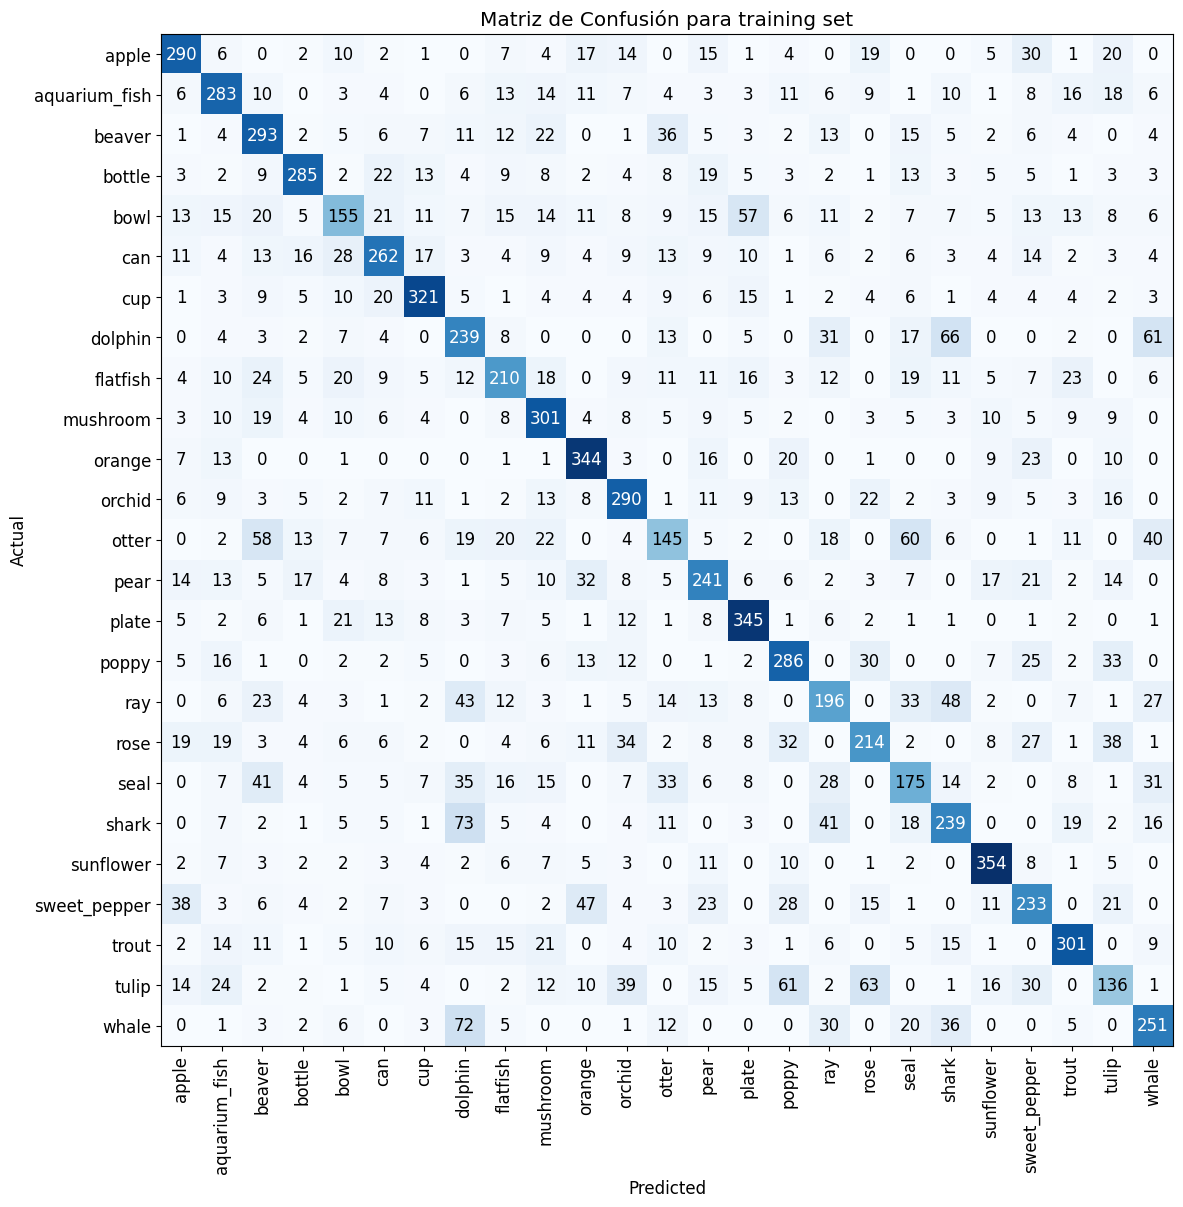

In [ ]:
interp = ClassificationInterpretation.from_learner(learn=learn, dl=dls.train)
cm = interp.confusion_matrix()

print('Número de ejemplos en train:', np.sum(cm))
interp.plot_confusion_matrix(figsize=(12, 12),title='Matriz de Confusión para training set')

Observando detenidamente la matriz de confusión vemos que en general no se discrimina a ninguna clase para máximizar la accuracy, en general los resultados de todas las clases son similares y no se discrimina ninguna etiqueta, alguna clase como tulip si está un poco menospreciada pero nada demasiado exagerado.

Y por último vamos a ver que tal se comporta el modelo con el conjunto de test, para ello primero creamos el dataloader de los datos de test.

En vez de crear el dataloader para test de cero usamos la función dls.test_dl(), lo que hace esta función es partiendo del dataloader que llama a la función (dls) crea un nuevo dataloader con las mismas características para el conjunto de datos que se le pases, este conjunto de datos se lo pasamos como una cadena que contiene la ruta de cada imagen de test (test_files), el otro argumento que añadimos (with_labels=True) es para indicar que el DataLoader debe cargar las etiquetas, las cuales necesitaremos para evaluar el rendimiento del modelo.

In [ ]:
test_files = [fn for fn in sorted((path/'test').glob('**/*')) if fn.is_file()]

test_dl = learn.dls.test_dl(test_files,with_labels=True)

Luego al igual que para train usamos la función get_preds() para obtener las predicciones.

In [ ]:
preds, targs, _ = learn.get_preds(dl=test_dl, with_decoded=True)

Y de nuevo misma función para calcular la accuracy que en train.

In [ ]:
acc = accuracy(preds, targs)
print('La accuracy para test es : ', round(float(acc)*100, 4), '%')

La accuracy para test es :  39.56 %


La cual vemos que tiene un valor similar a la de validación, son resultados bajos, pero claro estamos entrenando un modelo base, en el siguiente ejercicio intentaremos ya mejorarlos.

Por último imprimimos también la matriz de confusión para sacar conclusiones de que tal funciona el modelo para conjuntos de fuera de la muestra.

Número de ejemplos para test: 2500


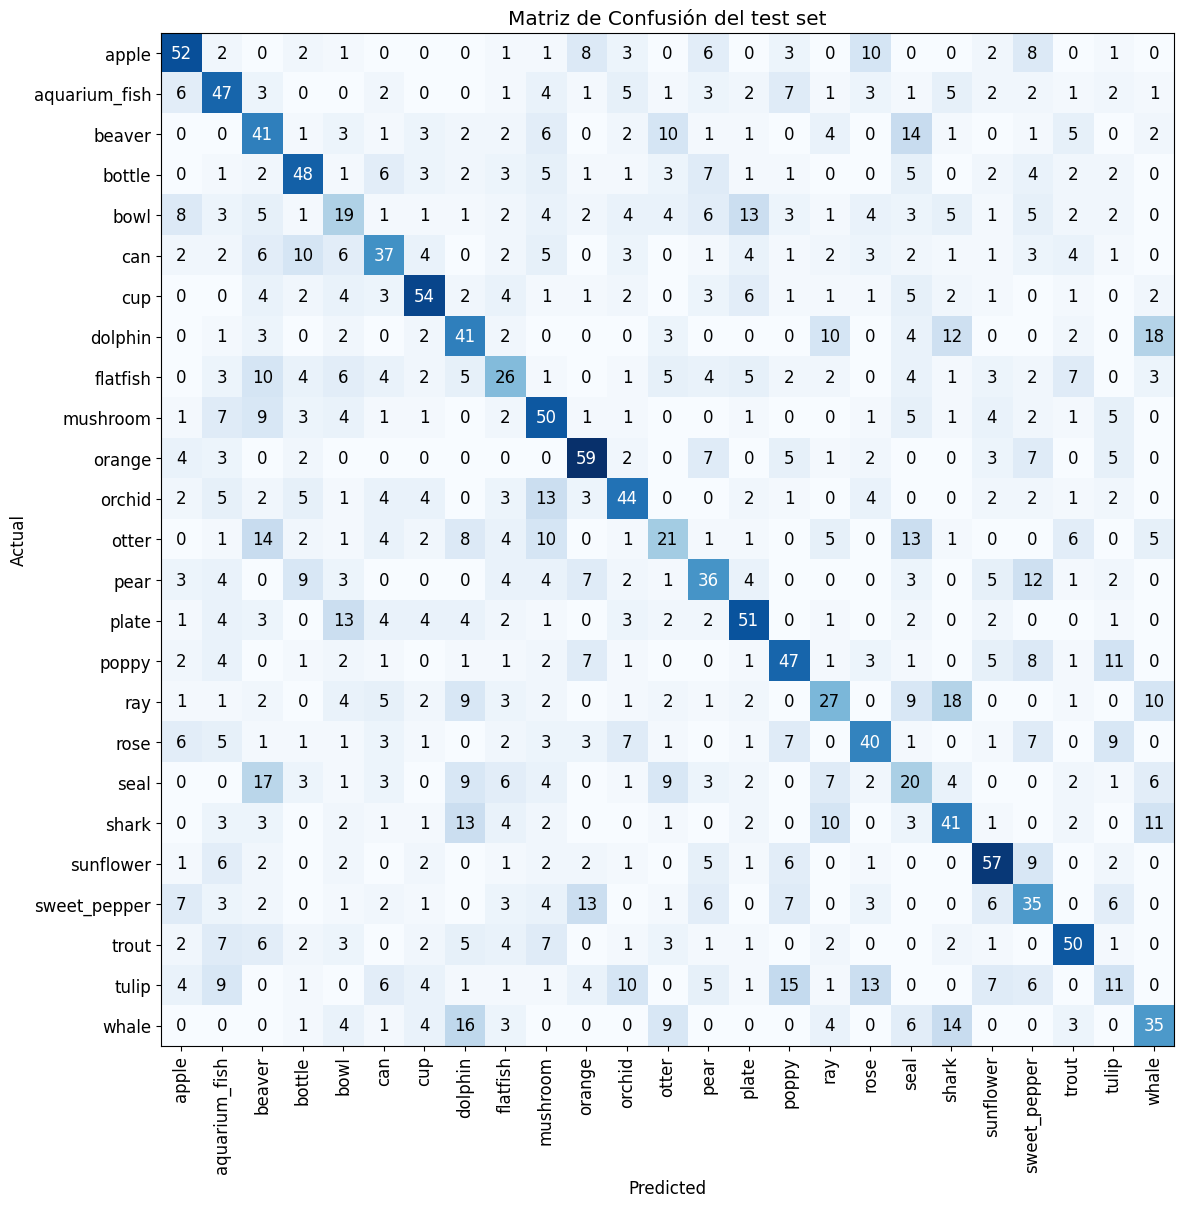

In [ ]:
interp = ClassificationInterpretation.from_learner(learn, 1, test_dl)
cm = interp.confusion_matrix()

print('Número de ejemplos para test:', np.sum(cm))
interp.plot_confusion_matrix(figsize=(12, 12),title='Matriz de Confusión del test set')

Observamos los mismos problemas que tenía el modelo con el training set, algunas clases como tulip o seal son menospreciadas, en esta ocasión en mayor medida, aunque por ejemplo en el caso de tulip no hay otra clase en cuestión con la que se confunda, sino que etiqueta un poco aleatoriamente. Seal por otro lado si que es más una confusión con beaver.

Habrá que vigilar que estos comportamientos no se repitan con el modelo mejorado.

Por último muestro cuales han sido las imágenes peor clasificadas, es decir, con un valor de la función de pérdida mayor, para ello uso la función plot_top_losses(), a la cual le indico el número de imágenes que quiero ver.

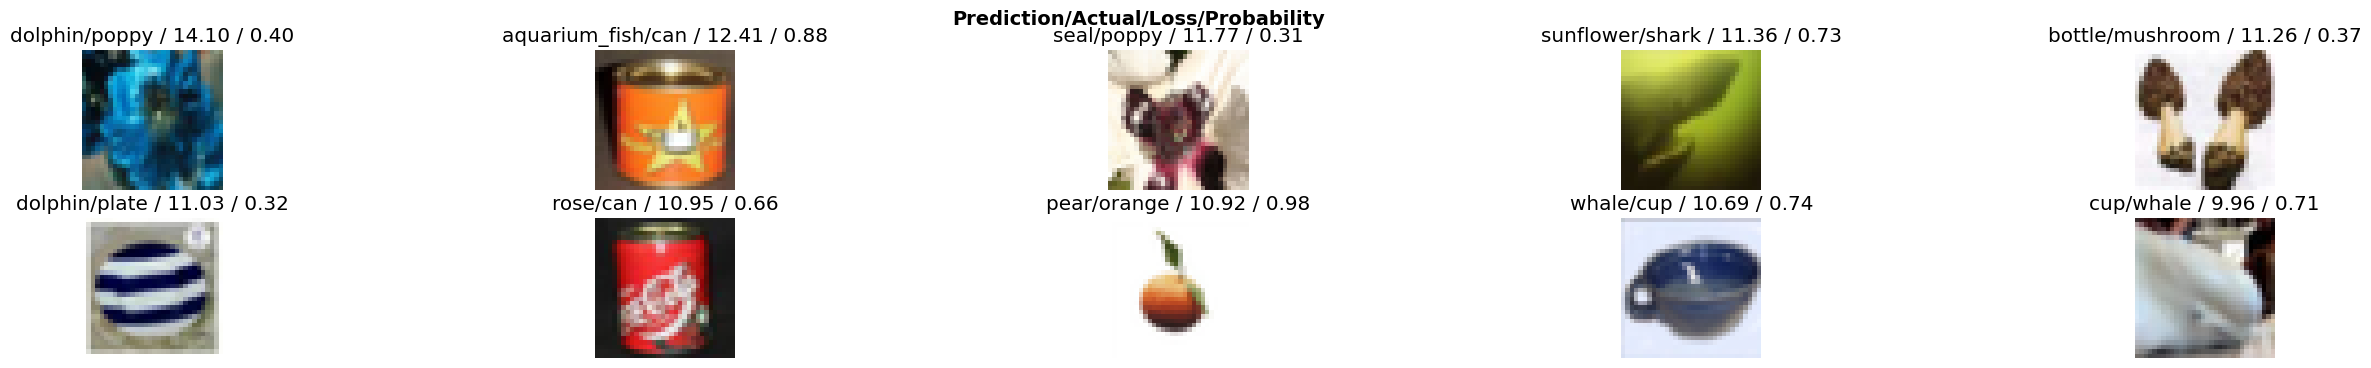

In [ ]:
interp.plot_top_losses(10, nrows=2, figsize=(32,4))

No termino de verle la funcionalidad, me refiero que conclusiones se pueden obtener de ver las 10 imágenes peor clasificadas, tal vez si existe algún patrón concreto para intentar solucionarlo, cosa que no se observa en este caso.

<font color='blue'>What is the total number of parameters of the created model? Break down the account made to reach that figure.



El número total de parámetros es 43427, este valor lo podemos obtener automáticamente mendiante la función total_params(), solo hay que pasarle a la función la red de la que queremos conocer el número total de parámetros final.

No obstante también se puede calcular este número de forma manual, teniendo en cuenta las dimensiones del primer input de la red y yendo actualizando esa dimensión según se van pasando capas de la red.

La cuenta sería la siguiente:
Capa 1 (Conv2d):
  - Pesos: (out_channels x in_channels x kernel_size x kernel_size) + out_channels (sesgos)
  - (4 x 3 x 7 x 7) + 4 = 592 parámetros

Capa 2 (ReLU):
  - No hay parámetros entrenables en la función de activación ReLU.

Capa 3 (MaxPool2d):
  - No hay parámetros entrenables en la capa de MaxPool2d.

Capa 4 (Conv2d):
  - Pesos: (out_channels x in_channels x kernel_size x kernel_size) + out_channels (sesgos)
  - (10 x 4 x 5 x 5) + 10 = 1010 parámetros

Capa 5 (ReLU):
  - No hay parámetros entrenables en la función de activación ReLU.

Capa 6 (Flatten):
  - No hay parámetros entrenables en la capa de Flatten.

Capa 7 (Linear):
  - Pesos: (out_features x in_features) + out_features (sesgos)
  - (50 x 810) + 50 = 40550 parámetros

Capa 8 (ReLU):
  - No hay parámetros entrenables en la función de activación ReLU.

Capa 9 (Linear):
  - Pesos: (out_features x in_features) + out_features (sesgos)
  - (25 x 50) + 25 = 1275 parámetros

Total de Parámetros: Sumar los parámetros de cada capa, 592 + 1010 + 40550 + 1275 = 43427 parámetros.


<font color='blue'>When fastai is used, and a multiclass classification problem like the one indicated in this exercise is addressed, is it necessary to incorporate a SoftMax function (`nn.Softmax()`) as last layer/element/component of your model? Justify the answer.

No, ya que internamente fastai al llamar a la función CrossEntropyLossFlat() se encarga de ello como se puede ver en la documentación.

Código interno de la función que aparece en la documentación https://docs.fast.ai/losses.html#crossentropylossflat:


```
tst = CrossEntropyLossFlat(reduction='none')
output = torch.randn(32, 5, 10)
target = torch.randint(0, 10, (32,5))
#nn.CrossEntropy would fail with those two tensors, but not our flattened version.
_ = tst(output, target)

test_fail(lambda x: nn.CrossEntropyLoss()(output,target))

#Associated activation is softmax
test_eq(tst.activation(output), F.softmax(output, dim=-1))
#This loss function has a decodes which is argmax
test_eq(tst.decodes(output), output.argmax(dim=-1))
```





---



---



---



# <font color='blue'> **Exercise 2:** **Improvement of the BaseNet model (3.5 points)**
<font color='blue'>Now the goal is to create, by making judicious architectural and implementation choices, an enhanced deep network based on *BaseNet*. Students should perform a sensible combination of different elements, which may include all or some of the following: Convolutional layers (Conv2D, either normal or atrous), Pooling layers (Local and Global MaxPooling2D and AveragePooling2D), Dense layers (also called fully-connected (FC) layers), Non-linear activations, (e.g. ReLu, leaky ReLu, etc.), Flattening (i.e. convert 2D features to 1D features),  Batch Normalization, and/or Regularization (e.g. Dropout or weight decay).

<font color='blue'>It is necessary to emphasize that **it is essential to justify the decisions made in the best possible way** (either through empirical evidence or through scientific literature).

<font color='blue'>A good combination of layers can largely improve the performance of our new model on these data. To enhance your network, you may consider adding any combination of the following enhancement options:
1. **Data normalization**. Scale normalization of the input data, in general, makes training easier and more robust. Use the DataLoader or ImageDataLoaders class with the correct parameters so that the data is well conditioned (mean=0, stddev=1) to improve training. You must ensure that test_transform uses the same normalization parameters as train_transform.
2. **Batch normalization**. Batch-normalization layers in most cases help to reduce overfitting and improve model training. Add normalization layers after convolutional layers and before the ReLU layer, but try including it after ReLU layers as well.
3. **Depth increase**. Experiment adding convolutional layers. Do not always put a maxpool layer after each conv layer, as this leads to excessive loss of information by reducing the number of units. If needed use UpSampling (Transposed Convolution) layers to increase the number of units.
4. **Dropout**. This layer introduces regularization by randomly selecting a percentage of active neurons for each mini-batch. This helps the network to specialize neurons in specific and independent information.
5. **Early Stopping**. After how many epochs we should stop training? Keep in mind that you should never use the test set for anything other than the final evaluation. You should decide for how many epochs you will train your model by looking at the training loss and validation accuracy plots (to do so, evaluate the local minima/maxima of the loss function as well as the classification accuracy). Remember that if you choose too many epochs it would quite likely lead to overfitting, while if you select too few your model quite likely won't  learn enough. In your report, you must include a table similar to the one shown in Exercise 1 to illustrate the architecture of your final improved network. In addition, you must explain the steps taken with the partial results obtained that have finally led you to introduce the proposed modifications.
6. **Data augmentation**.  Use the DataLoader or ImageDataLoaders class data zoom parameters, like zoom_range and/or horizontal_flip. Remember that you should not have any data augmentation in the validation or test sets. If you need a better understanding, try reading fastai's tutorial on transformations. Look at data augmentation using image transformations.

<font color='blue'> Feel free to incorporate modifications not included in the aforementioned list.

Esquema final de la red neuronal usada:

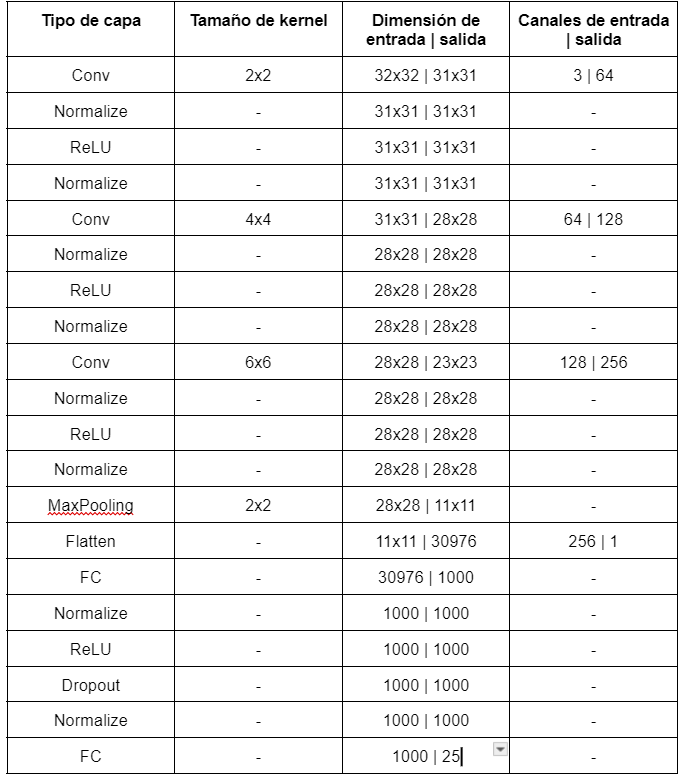

La primera mejora que haré será en el DataBlock, en vez de una normalización cuyos valores son entrenados con el dataset train, usaré los valores de normalización ya existentes del dataset de Imagenette, este es un dataset de imágenes enorme, por lo tanto sus estadísticas de media y desviación típica son más fieles a la realidad que los calculados con nuestro pequeño dataset.

Este cambio hará que el modelo sea capaz de generalizar mejor a la hora de normalizar las imágenes y por tanto funcionará mejor con conjuntos de fuera de la muestra.

También usamos la función *aug_transforms(), lo que hace esta función es hacer transformaciones en las imágenes, por ejemplo volteándolas o modificando su brillo, esto para que el modelo sea capaz de reconocer tanto imágenes normales, por ejemplo un gato de pie, como imágenes modificadas, por ejemplo un gato tumbado, en resumen, esta función ayudará a que el modelo generalice mejor.

Estas transformaciones solo son aplicadas a los datos de entrenamiento.

In [ ]:
dbk = DataBlock(
                blocks = (ImageBlock, CategoryBlock),
                get_items = get_image_files,
                splitter = RandomSplitter(valid_pct=0.1, seed=0), # 10% validación como dice el guión
                get_y = parent_label,
                batch_tfms = [*aug_transforms(), Normalize.from_stats(*imagenet_stats)]
)

dbk.summary(path/'train')

Setting-up type transforms pipelines
Found 12500 items
2 datasets of sizes 11250,1250
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/cifar100/train/aquatic_mammals/whale/right_whale_s_000185.png
    applying PILBase.create gives
      PILImage mode=RGB size=32x32
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/cifar100/train/aquatic_mammals/whale/right_whale_s_000185.png
    applying parent_label gives
      whale
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(24)

Final sample: (PILImage mode=RGB size=32x32, TensorCategory(24))


Found 12500 items
2 datasets of sizes 11250,1250
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': N

Ahora pasamos a crear el dataloader, volvemos a elegir batches de 32 elementos, para tener una mayor regularización y que el modelo generalice mejor.

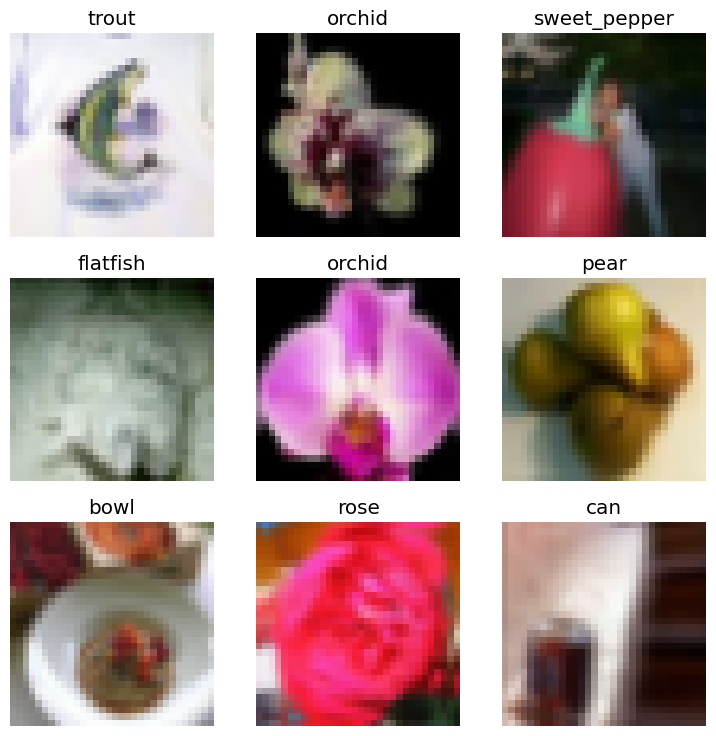

In [ ]:
dls = dbk.dataloaders(path/'train', bs=32)

dls.show_batch() # Muestra un conjunto de imágenes

Vamos ahora a crear nuestra propia red neuronal, este es el paso más importante, ya que los pesos se actualizan y entrenan aquí, por lo que tener una buena estructura de red neuronal es clave para obtener buenos resultados.

Aparte de las funciones antes usadas, usaré algunas nuevas, cuyo funcionamiento explico a continuación:
* BatchNorm2d(): Esta capa realiza la normalización por lotes, lo que puede ayudar a mejorar la convergencia del modelo y la generalización. Sus argumentos son:
  * num_features: Este es el número de canales en la entrada.
  * eps: Este es el término de suavizado para evitar la división por cero en el cálculo de la desviación estándar. Por defecto, eps=1e-5.
  * momentum: Este parámetro controla la tasa de actualización de la media y la varianza durante el entrenamiento. Un valor típico es momentum=0.1. Un valor de momentum=1.0 significa que la estadística se calcula completamente en cada lote, mientras que un valor menor significa que se da más peso a las estadísticas anteriores. Por defecto, momentum=0.1.
  * affine: Si es True, se aprenden y aplican parámetros de escala y sesgo. Si es False, affine deshabilita estos parámetros. Por defecto, affine=True.
  * track_running_stats: Si es True, realiza un seguimiento de las estadísticas de ejecución (media y varianza) durante el entrenamiento. Por defecto, track_running_stats=True.

* Dropout(): Durante el entrenamiento aleatoriamente se pone a cero (anula) un porcentaje de las unidades de salida de la capa anterior. Esto ayuda a prevenir que la red se vuelva demasiado dependiente de ciertas conexiones y mejora la generalización del modelo.

La estructura es la siguiente:
* Capa Conv2d: Lo primero que queremos es extraer características de las imágenes, los canales de entrada son 3, uno por color, los de salida 64, para así extraer una cantidad mayor de características, al ser la primera capa queremos extraer muchos detalles pequeños de las imágenes, en esta línea seleccionamos también un tamaño pequeño de kernel, 2, para obtener características más detalladas.

* Capa BatchNorm2d: Capa de normalización tras obtener las nuevas variables para mantener una media y desviación típica estables y así tener un mejor entrenamiento.

* Capa ReLU: Tras la extracción de características buscamos relaciones no lineales en las mismas.

* Capa BatchNorm2d: Volvemos a normalizar.

* Capa Conv2d: Ahora que ya hemos extraido detalles finos de las imágenes queremos extraer detalles más generales, para ello uso un kernel mayor, 4. En cuanto a los canales sigo aumentandolos para recoger el máximo número de características posible, claro que el número de las mismas va a aumentar considerablemente.

* Capas normalizado, ReLU, normalizado: Al igual que antes hacemos el mismo procedimiento de normalizar primero, extraer relaciones con la función de activación ReLU y volver a normalizar.

* Capa Conv2d: Usamos una última capa Conv2d para extraer ya detalles más gruesos, de ahí el tamaño de kernel 6, aumento los canales también para extraer el máximo posible de características.

* Capas normalizado, ReLU, normalizado: Al igual que antes hacemos el mismo procedimiento de normalizar primero, extraer relaciones con la función de activación ReLU y volver a normalizar.

* Capa MaxPool2d: Esta capa reduce la dimensión espacial de la entrada, permitiendo que la red capture características más importantes y reduciendo la cantidad de parámetros en capas subsiguientes. Debido al gran número de características que recopilan las capas anteriores uso esta capa para reducir ese número y eliminar las características más redundantes. Establezco el tamaño del kernel a 2 para tampoco eliminar demasiada información.

* Capa Flatten: Una vez tenemos un conjunto de características de más alto nivel pasamos la matriz 2D a un vector para poder aplicarle una capa FC.

* Capa Linear: Aplicamos una capa lineal, que realiza una transformación lineal de la entrada y reducimos el número de variables.

* Capas normalizado, ReLU, dropout, normalizado: Agregamos una capa dropout para que esta desactive neuronas en el entrenamiento y así el modelo no sobreentrene, ajustamos la probabilidad de desactivar una neurona al 50%.

* Capa linear: Aplicamos una última capa lineal para quedarnos con 25 variables, el número de clases que tenemos.

In [ ]:
# Ajustamos semillas para poder reproducir los experimentos
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
set_seed(seed)

In [ ]:
myNet = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=2), # kernel 2, pasa dimensión de 32x32 a 31x31
    nn.BatchNorm2d(num_features=64),
    nn.ReLU(),
    nn.BatchNorm2d(num_features=64),

    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4), # 31x31 --> 28x28
    nn.BatchNorm2d(num_features=128),
    nn.ReLU(),
    nn.BatchNorm2d(num_features=128),

    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=6), # 28x28 --> 23x23
    nn.BatchNorm2d(num_features=256),
    nn.ReLU(),
    nn.BatchNorm2d(num_features=256),
    nn.MaxPool2d(kernel_size=2), #23x23 --> 11x11

    nn.Flatten(), # 11x11 --> 121*256(dimensión * núm. canales)

    nn.Linear(in_features=121*256, out_features=1000), # 121*256 --> 1000
    nn.BatchNorm1d(num_features=1000),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.BatchNorm1d(num_features=1000),

    nn.Linear(in_features=1000, out_features=25) # Nº de clases
)

# Función para resetear los pesos
def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

total_params(myNet)

(32319753, True)

Creamos también una función que resetea los pesos de la red para poder hacer tuneo de hiperparámetros, lo que hace la función es ir capa por capa comprobando si esa capa tiene pesos, en cuyo caso los reinicia.

Observamos también el número de parámetros entrenables de la red, unos 32 millones, muchisimos más que en la red base.

Ahora pasamos a crear el modelo como tal, usamos los mismos parámetros que en el primer ejercicio, pero usando la nueva red neuronal, la función de error porque es un ejercicio de clasificación, el optimizador adam porque es el más comúnmente utilizado en esta clase de problemas y de métrica la accuracy ya que es bastante explicativa, luego ya imprimiremos también la matriz de confusión para comprobar si el modelo es realmente bueno.

In [ ]:
learn = Learner(dls=dls, model=myNet, loss_func=CrossEntropyLossFlat(), opt_func=Adam, metrics=accuracy)

Lo siguiente es encontrar el learning rate ideal al igual que antes, recordar que la forma de encontrarlo es seleccionando el lr que da un error bajo justo antes de que empiece a subir la tasa de error con valores de lr más altos.

SuggestedLRs(valley=0.0002754228771664202)


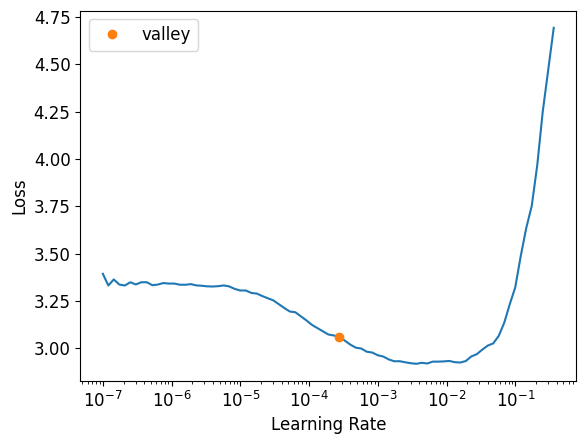

In [ ]:
# Realizar una búsqueda de tasa de aprendizaje
lr = learn.lr_find()

print(lr)

Por último entrenamos el modelo, para ello usamos la función fit_one_cycle() al igual que antes, solo que esta vez si que tunearé más los parámetros de la función para optimizarla. Para este tuneo de parámetros indicaré que se ejecuten solo 3 épocas para ir más rápido, ya hemos visto que antes al menos a la cuarta época empezaba a decaer la mejora en el entrenamiento.

Como lr_max usaré el ya obtenido como óptimo, al igual que en el ejercicio 1.

**div**

Lo que hace div es dividir lr_max por sí mismo para determinar el lr inicial, por defecto está a 25, un lr inicial mayor puede hacer que el modelo converja más rápido, pero si este es muy grande puede diverger, por otro lado un lr inicial pequeño hará que el modelo converja sea más despacio.

Probaré con 50, 25 y 12.

In [ ]:
print("\ndiv=50:")
learn.fit_one_cycle(n_epoch=3, lr_max=lr[0], reset_opt=True, div=50)
reset_weights(myNet) # Reinicio los pesos del modelo para entrenar de 0 y comparar

print("\ndiv=25:")
learn.fit_one_cycle(n_epoch=3, lr_max=lr[0], reset_opt=True, div=25)
reset_weights(myNet)

print("\ndiv=12:")
learn.fit_one_cycle(n_epoch=3, lr_max=lr[0], reset_opt=True, div=12)
reset_weights(myNet)


div=50:


epoch,train_loss,valid_loss,accuracy,time
0,2.291480,2.073983,0.375200,00:31
1,1.943828,1.727531,0.477600,00:30
2,1.720999,1.578966,0.500000,00:31



div=25:


epoch,train_loss,valid_loss,accuracy,time
0,2.240617,2.021458,0.392800,00:31
1,1.914685,1.726745,0.463200,00:31
2,1.652807,1.576702,0.494400,00:31



div=12:


epoch,train_loss,valid_loss,accuracy,time
0,2.244481,2.017493,0.377600,00:31
1,1.847675,1.623675,0.489600,00:31
2,1.610249,1.512769,0.523200,00:33


Vemos que en todos los casos obtenemos resultados similares, por lo que seleccionamos la opción por defecto.

**div_final**

En este caso lo que controlamos es el lr final, dividiendo de nuevo lr_max por este parámetro, cuyo valor por defecto es 100000, de nuevo un valor menor resultará en una reducción más pronunciada de la tasa de aprendizaje al final del ciclo, mientras que un valor mayor permitirá que la tasa de aprendizaje disminuya más suavemente.

Pruebo con 1000000, 100000, 10000.

In [ ]:
print("\ndiv_final=1000000:")
learn.fit_one_cycle(n_epoch=3, lr_max=lr[0], reset_opt=True, div_final=1000000)
reset_weights(myNet)

print("\ndiv_final=100000:")
learn.fit_one_cycle(n_epoch=3, lr_max=lr[0], reset_opt=True, div_final=100000)
reset_weights(myNet)

print("\ndiv_final=10000:")
learn.fit_one_cycle(n_epoch=3, lr_max=lr[0], reset_opt=True, div_final=10000)
reset_weights(myNet)


div_final=1000000:


epoch,train_loss,valid_loss,accuracy,time
0,2.261727,2.001798,0.374400,00:31
1,1.920420,1.704272,0.482400,00:31
2,1.651982,1.571613,0.497600,00:31



div_final=100000:


epoch,train_loss,valid_loss,accuracy,time
0,2.262454,2.035490,0.396000,00:31
1,1.906252,1.686622,0.483200,00:31
2,1.693703,1.578690,0.500000,00:30



div_final=10000:


epoch,train_loss,valid_loss,accuracy,time
0,2.283906,2.022205,0.376800,00:31
1,1.931460,1.670445,0.475200,00:31
2,1.642841,1.545156,0.513600,00:31


Vemos que cuando el lr_max es dividido por 10000, es decir es mayor que con los otros parámetros, obtenemos resultados algo mejores, supongo que porque al tener un lr mayor este converge más rápido, no obstante aquí solo usamos 3 épocas, cuando use más está la posibilidad de que en las últimas épocas diverja por tener un lr grande.

Elegiré div_final=10000 y estaré atento a la hora de hacer el entrenamiento final.

**pct_start**

Fracción del ciclo por la cual la tasa de aprendizaje aumenta, establecido en 25%, al igual que antes mayor lr más probabilidad de diverger y por los resultados obtenidos hasta ahora sospecho que estamos cerca de ello.

Probaré con 10%, 25% y 50%.

In [ ]:
print("\npct_start=0.1:")
learn.fit_one_cycle(n_epoch=3, lr_max=lr[0], reset_opt=True, div_final=10000, pct_start=0.1)
reset_weights(myNet)

print("\npct_start=0.25:")
learn.fit_one_cycle(n_epoch=3, lr_max=lr[0], reset_opt=True, div_final=10000, pct_start=0.25)
reset_weights(myNet)

print("\npct_start=0.5:")
learn.fit_one_cycle(n_epoch=3, lr_max=lr[0], reset_opt=True, div_final=10000, pct_start=0.5)
reset_weights(myNet)


pct_start=0.1:


epoch,train_loss,valid_loss,accuracy,time
0,2.226217,1.971267,0.364800,00:31
1,1.925692,1.669359,0.480000,00:30
2,1.617705,1.562099,0.504800,00:31



pct_start=0.25:


epoch,train_loss,valid_loss,accuracy,time
0,2.272295,2.061255,0.390400,00:32
1,1.928382,1.684026,0.468000,00:30
2,1.689763,1.577131,0.499200,00:30



pct_start=0.5:


epoch,train_loss,valid_loss,accuracy,time
0,2.299870,2.111884,0.357600,00:31
1,2.039136,1.807900,0.444000,00:31
2,1.758311,1.590708,0.493600,00:31


Todos dan más o menos los mismos resultados finales, por lo que dejo la opción por defecto.

**wd**

Controla la regularización L2, vemos por las ejecuciones anteriores que empezamos a tener sobreajuste, el error en train empieza a ser menor que en validación, por lo que vendría bien controlarlo mediante regularización, ya que esta viene por defecto a None.

Porbaré 0.001, 0.01 y 0.1

In [ ]:
print("\nwd=0.1:")
learn.fit_one_cycle(n_epoch=3, lr_max=lr[0], reset_opt=True, div_final=10000, wd=0.1)
reset_weights(myNet)

print("\nwd=0.01:")
learn.fit_one_cycle(n_epoch=3, lr_max=lr[0], reset_opt=True, div_final=10000, wd=0.01)
reset_weights(myNet)

print("\nwd=0.001:")
learn.fit_one_cycle(n_epoch=3, lr_max=lr[0], reset_opt=True, div_final=10000, wd=0.001)
reset_weights(myNet)


wd=0.1:


epoch,train_loss,valid_loss,accuracy,time
0,2.264146,2.051546,0.376800,00:30
1,1.939062,1.714528,0.473600,00:31
2,1.676872,1.565490,0.509600,00:31



wd=0.01:


epoch,train_loss,valid_loss,accuracy,time
0,2.271027,2.031865,0.372800,00:31
1,1.957456,1.726667,0.457600,00:30
2,1.682574,1.594518,0.497600,00:30



wd=0.001:


epoch,train_loss,valid_loss,accuracy,time
0,2.248093,2.040471,0.382400,00:31
1,1.958411,1.690532,0.481600,00:31
2,1.700927,1.557810,0.512800,00:31


Todas las opciones dan más o menos los mismos resultados, seleccionaré la opción media, 0.01 para tener algo de protección frente al sobreajuste más allá del dropout.

Por último, ya para hacer el entrenamiento final, creo un callback para controlar el early stop, para ello uso el callback EarlyStoppingCallback, este callback detendrá el entrenamiento del modelo si no se observa ninguna mejora en la métrica de validación después de un cierto número de épocas. Esto también para protegerme de sobreajuste y parar el entrenamiento cuando las métricas de error de validación dejen de mejorar.

Los parámetros que le paso son:
* monitor='valid_loss' indica que se realizará un seguimiento de la pérdida en el conjunto de validación para decidir si detener el entrenamiento.
* min_delta=0.01 especifica la cantidad mínima de cambio en la métrica que se considera como mejora. Si la métrica no mejora en al menos min_delta, se cuenta como un estancamiento.
* patience=3 indica cuántas épocas esperar después de que la métrica no mejore antes de detener el entrenamiento.

epoch,train_loss,valid_loss,accuracy,time
0,2.298605,2.124261,0.352000,00:32
1,2.111951,1.915390,0.392800,00:34
2,1.916968,1.679506,0.477600,00:33
3,1.703518,1.547002,0.502400,00:33
4,1.537166,1.428775,0.544000,00:34
5,1.455919,1.366586,0.559200,00:38
6,1.381537,1.289583,0.585600,00:36
7,1.215517,1.243720,0.598400,00:32
8,1.168792,1.213453,0.598400,00:31
9,1.131907,1.217230,0.598400,00:36


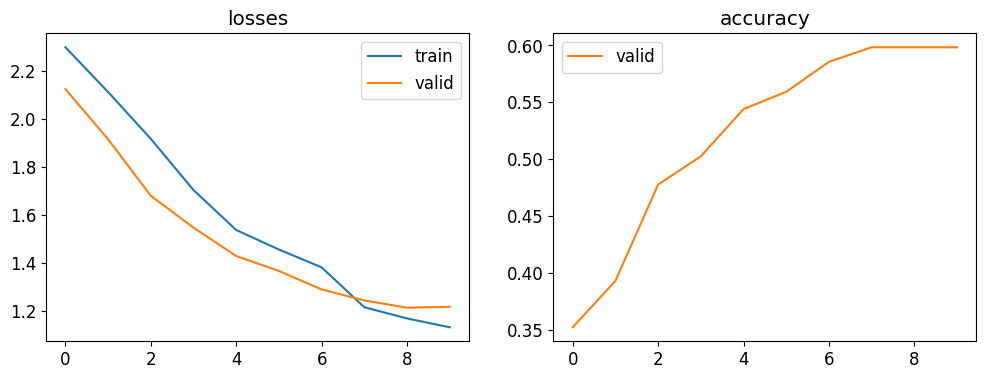

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 31 x 31   
Conv2d                                    832        True      
BatchNorm2d                               128        True      
ReLU                                                           
BatchNorm2d                               128        True      
____________________________________________________________________________
                     32 x 128 x 28 x 28  
Conv2d                                    131200     True      
BatchNorm2d                               256        True      
ReLU                                                           
BatchNorm2d                               256        True      
____________________________________________________________________________
                     32 x 256 x 23 x 23  
Conv2d                                    1179904    True      
BatchNorm2d                          

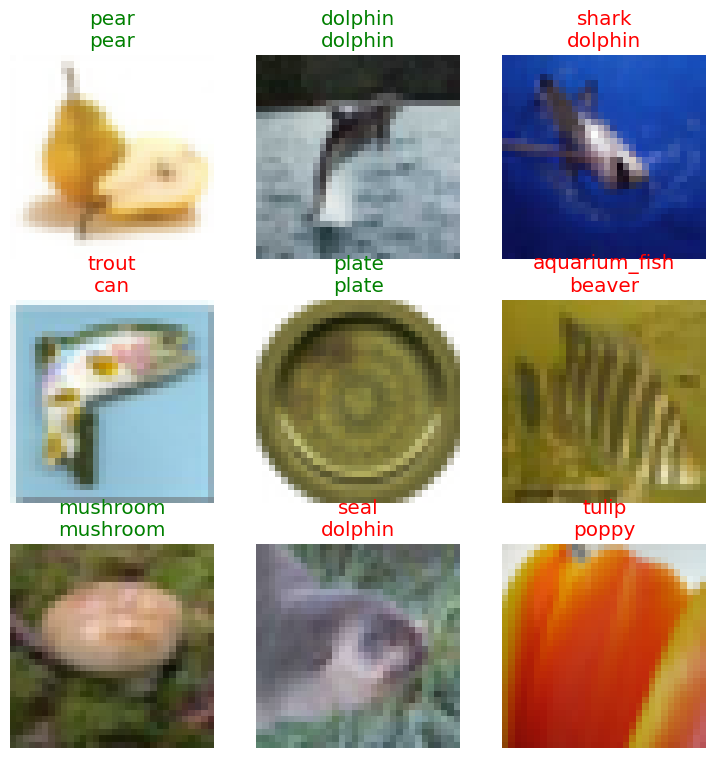

In [ ]:
early_stopping_cb = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=3)

learn.fit_one_cycle(n_epoch=10, lr_max=lr[0], reset_opt=True, div_final=10000, wd=0.01, cbs=early_stopping_cb)
learn.recorder.plot_metrics() # muestra la gráfica de la accuracy
learn.show_results()
learn.summary() # resumen del entrenamiento

Al final el early stopping no se activa con tan pocas épocas, tampoco seguiré entrenando, ya que como se observa en las gráficas el error en validación empieza ya a estancarse y comienza a existir sobreajuste, por lo que 10 épocas ha sido suficiente.

Imprimo también la estructura de la red para que se pueda observar con más detenimiento que capas la forman.

Ahora vamos a detenernos y observar algunas métricas de error para estudiar que tan buenos han sido los resultados. Empezamos con la accuracy.

In [ ]:
preds, targs, _ = learn.get_preds(dl=dls.train, with_decoded=True)

# Calculamos la accuracy en train
acc = accuracy(preds, targs)
print('Accuracy en train : ', round(float(acc)*100, 4), '%')

Accuracy en train :  69.5556 %


In [ ]:
preds, targs, _ = learn.get_preds(dl=dls.valid, with_decoded=True)

# Calculamos la accuracy en validación
acc = accuracy(preds, targs)
print('Accuracy en validación : ', round(float(acc)*100, 4), '%')

Accuracy en validación :  59.84 %


Podemos ver lo que ya comentaba antes, empieza ha existir un gap entre la accuracy en train y la de validación (sobreajuste), pero este aún es pequeño, por lo que hemos parado el entrenamiento en el momento exacto.

En cuanto al valor de la accuracy en validación como tal, un 60% no es un gran resultado, aunque vemos una clara mejora respecto a la baseNet, cosa normal debido a la complejidad de la nueva red.

Para mejorar los resultados tal vez se podría probar a añadir más capas de convolución y obtener más características de las imágenes, aunque esto aumentaría el tiempo de cómputo claro.

Otra opción sería hacer un preentreno con un modelo ya existente para obtener unos pesos iniciales y ya entrenar con nuestra red para mejorar esos pesos ya inicializados.

Decido por tanto aumentar la red con una nueva capa de convolución, más el pack de normalización y función de activación, para ver como evolucionan los resultados.

In [ ]:
# Ajustamos semillas para poder reproducir los experimentos
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
set_seed(seed)

Adicionalmente añado un padding=1 en la primera convolución para no perder dimensionalidad ahí, ya que hay evidencias empíricas de que no es recomendable perder dimensionalidad de primeras.

In [ ]:
myNet2 = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=2, padding=1), # kernel 2, pero padding 1, no cambia dimensionalidad
    nn.BatchNorm2d(num_features=64),
    nn.ReLU(),
    nn.BatchNorm2d(num_features=64),

    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4), # 32x32 --> 29x29
    nn.BatchNorm2d(num_features=128),
    nn.ReLU(),
    nn.BatchNorm2d(num_features=128),

    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=6), # 29x29 --> 24x24
    nn.BatchNorm2d(num_features=256),
    nn.ReLU(),
    nn.BatchNorm2d(num_features=256),

    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=8), # 24x24 --> 17x17
    nn.BatchNorm2d(num_features=512),
    nn.ReLU(),
    nn.BatchNorm2d(num_features=512),
    nn.MaxPool2d(kernel_size=2), #17x17 --> 9x9

    nn.Flatten(), # 9x9 --> 81*512(dimensión * núm. canales)

    nn.Linear(in_features=81*512, out_features=1000), # 81*512 --> 1000
    nn.BatchNorm1d(num_features=1000),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.BatchNorm1d(num_features=1000),

    nn.Linear(in_features=1000, out_features=25) # Nº de clases
)

total_params(myNet2)

(51206921, True)

Creamos el learner igual que antes, pero con la nueva red neuronal.

In [ ]:
learn2 = Learner(dls=dls, model=myNet2, loss_func=CrossEntropyLossFlat(), opt_func=Adam, metrics=accuracy)

SuggestedLRs(valley=9.120108734350652e-05)


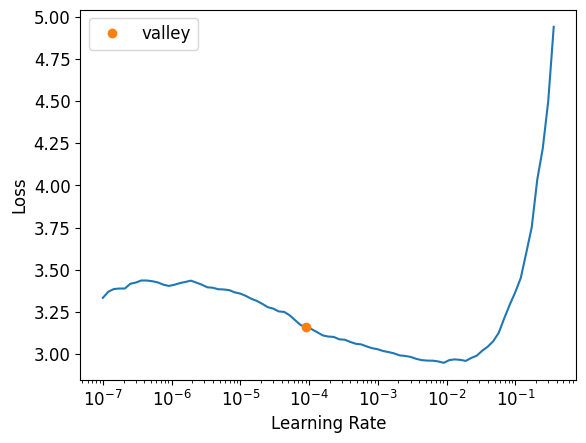

In [ ]:
# Realizar una búsqueda de tasa de aprendizaje
#lr = learn2.lr_find()

#print(lr)

Y entrenamos también con los mismos parámetros que antes, al tener una red más profunda hay más riesgo de sobreajuste y tal vez debería haber probado a tunear el hiperparámetro wd, pero confiaré en que 0.01 es suficiente aún, aparte con el early stopping no debería haber mayor problema.

epoch,train_loss,valid_loss,accuracy,time
0,2.339949,2.176302,0.348800,01:16
1,2.165615,1.961784,0.387200,01:11
2,1.963105,1.785847,0.452800,01:11
3,1.793587,1.607529,0.488800,01:12
4,1.634118,1.491681,0.537600,01:11
5,1.469334,1.425412,0.544800,01:10
6,1.347678,1.297367,0.590400,01:09
7,1.229548,1.257415,0.596000,01:10
8,1.156118,1.215861,0.609600,01:09
9,1.118141,1.214161,0.615200,01:09


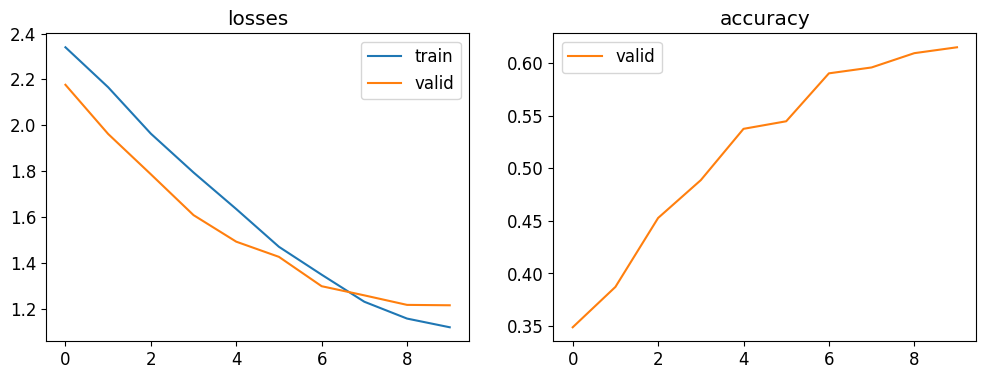

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 33 x 33   
Conv2d                                    832        True      
BatchNorm2d                               128        True      
ReLU                                                           
BatchNorm2d                               128        True      
____________________________________________________________________________
                     32 x 128 x 30 x 30  
Conv2d                                    131200     True      
BatchNorm2d                               256        True      
ReLU                                                           
BatchNorm2d                               256        True      
____________________________________________________________________________
                     32 x 256 x 25 x 25  
Conv2d                                    1179904    True      
BatchNorm2d                          

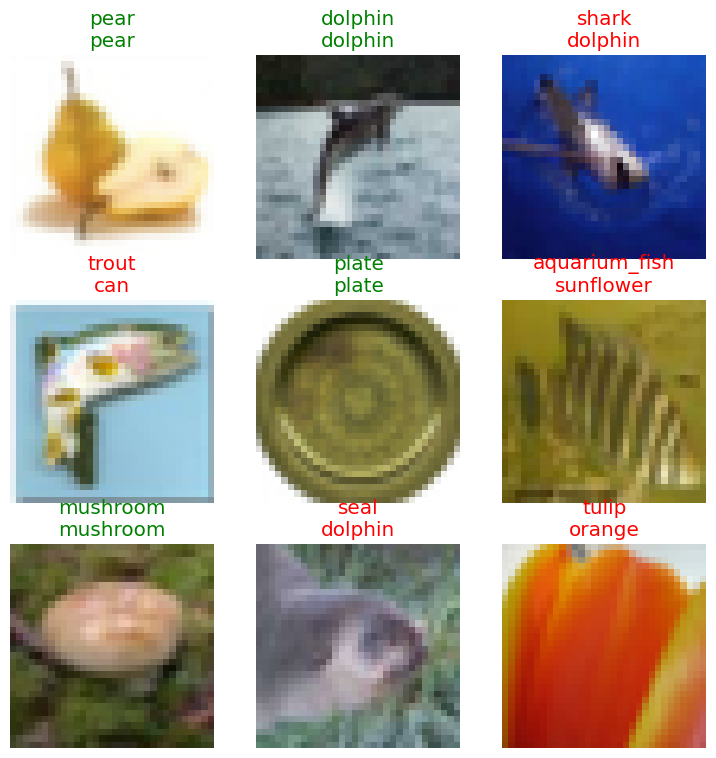

In [ ]:
"""
learn2.fit_one_cycle(n_epoch=10, lr_max=lr[0], reset_opt=True, div_final=10000, wd=0.01, cbs=early_stopping_cb)
learn2.recorder.plot_metrics() # muestra la gráfica de la accuracy
learn2.show_results()
learn2.summary() # resumen del entrenamiento
"""

Los resultados eran prácticamente idénticos a los de la primera red neuronal, por lo que el gasto de tiempo es innecesario y es más conveniente usar esa primera versión de la red, he comentado el entrenamiento ya que supone 10 minutos de código y al final eso no se obtiene una mejora sustancial.

Continuamos entonces viendo los resultados ofrecidos por el primer learner, seguimos con la matriz de confusión, vamos a ver primero la de train para ver si el modelo obviara algunas etiquetas para predecir otras más.

Número de ejemplos en train: 11250


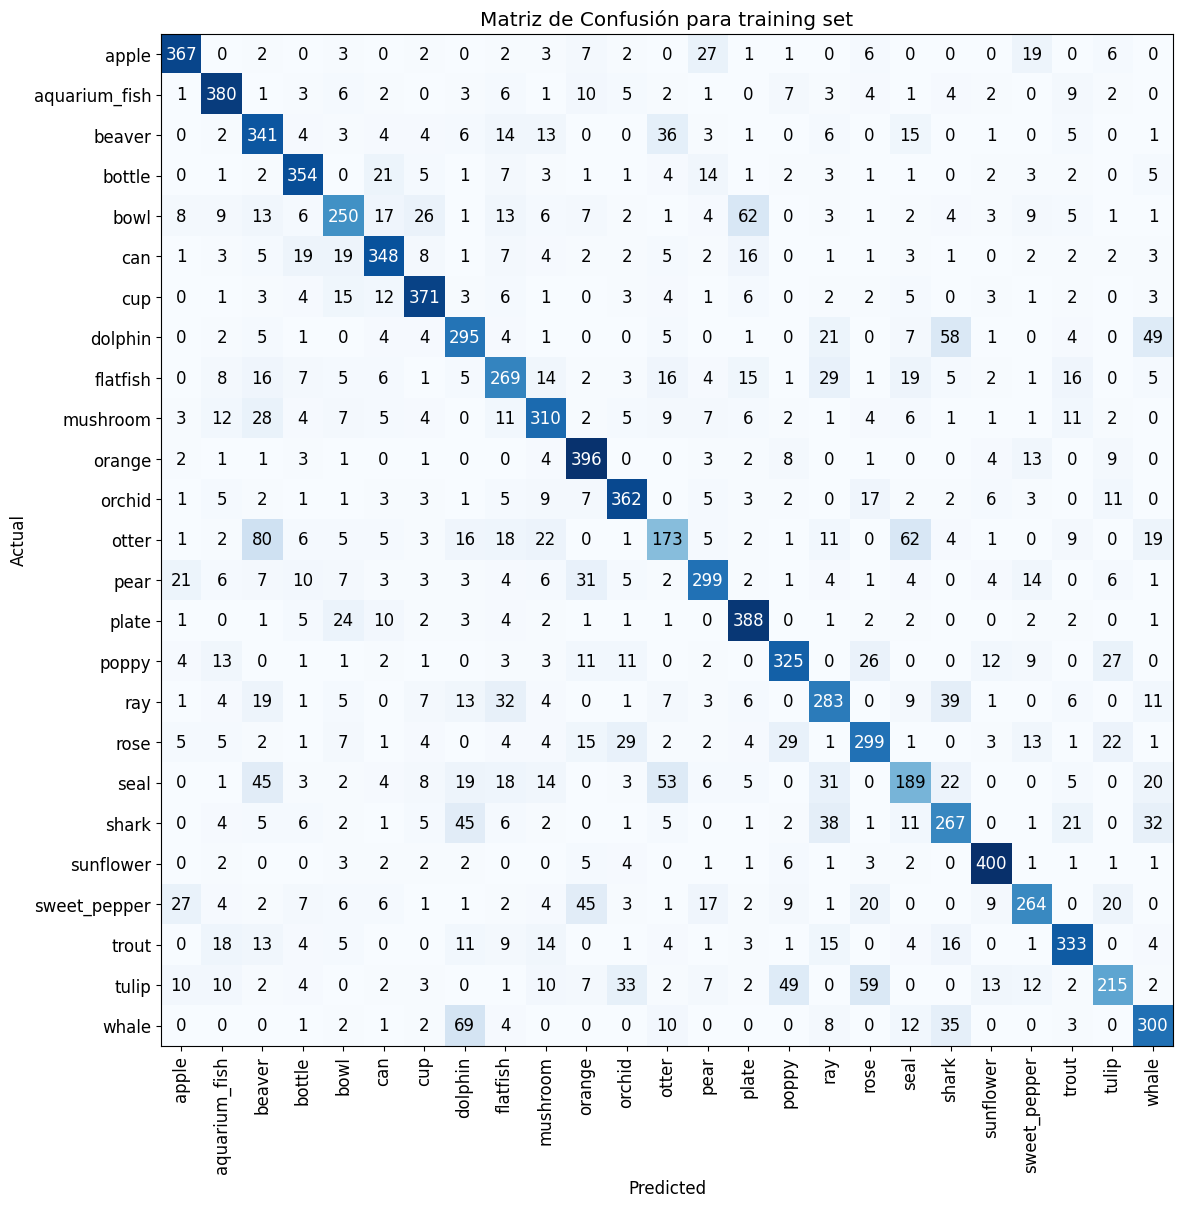

In [ ]:
interp = ClassificationInterpretation.from_learner(learn=learn, dl=dls.train)
cm = interp.confusion_matrix()

print('Número de ejemplos en train:', np.sum(cm))
interp.plot_confusion_matrix(figsize=(12, 12),title='Matriz de Confusión para training set')

Observamos que al menos en train, no hay ningún tipo de discriminación a alguna de las clases, todas se predicen de forma correcta más o menos en la misma proporción.

Por último vamos a ver que tal se comporta el modelo en test y si este realmente generaliza bien como parece que hace en validación.

In [ ]:
test_files = [fn for fn in sorted((path/'test').glob('**/*')) if fn.is_file()]

test_dl = learn.dls.test_dl(test_files,with_labels=True)

In [ ]:
preds, targs, _ = learn.get_preds(dl=test_dl, with_decoded=True)

In [ ]:
acc = accuracy(preds, targs)
print('La accuracy para test es : ', round(float(acc)*100, 4), '%')

La accuracy para test es :  63.44 %


Para la accuracy vemos que es prácticamente el mismo valor que teníamos en validación, lo cual es bastante buena señal, aunque de nuevo un 63% no es un gran resultado tampoco.

Por último vamos a observar la matriz de confusión a ver que tal predice el modelo las múltiples clases.

Número de ejemplos para test: 2500


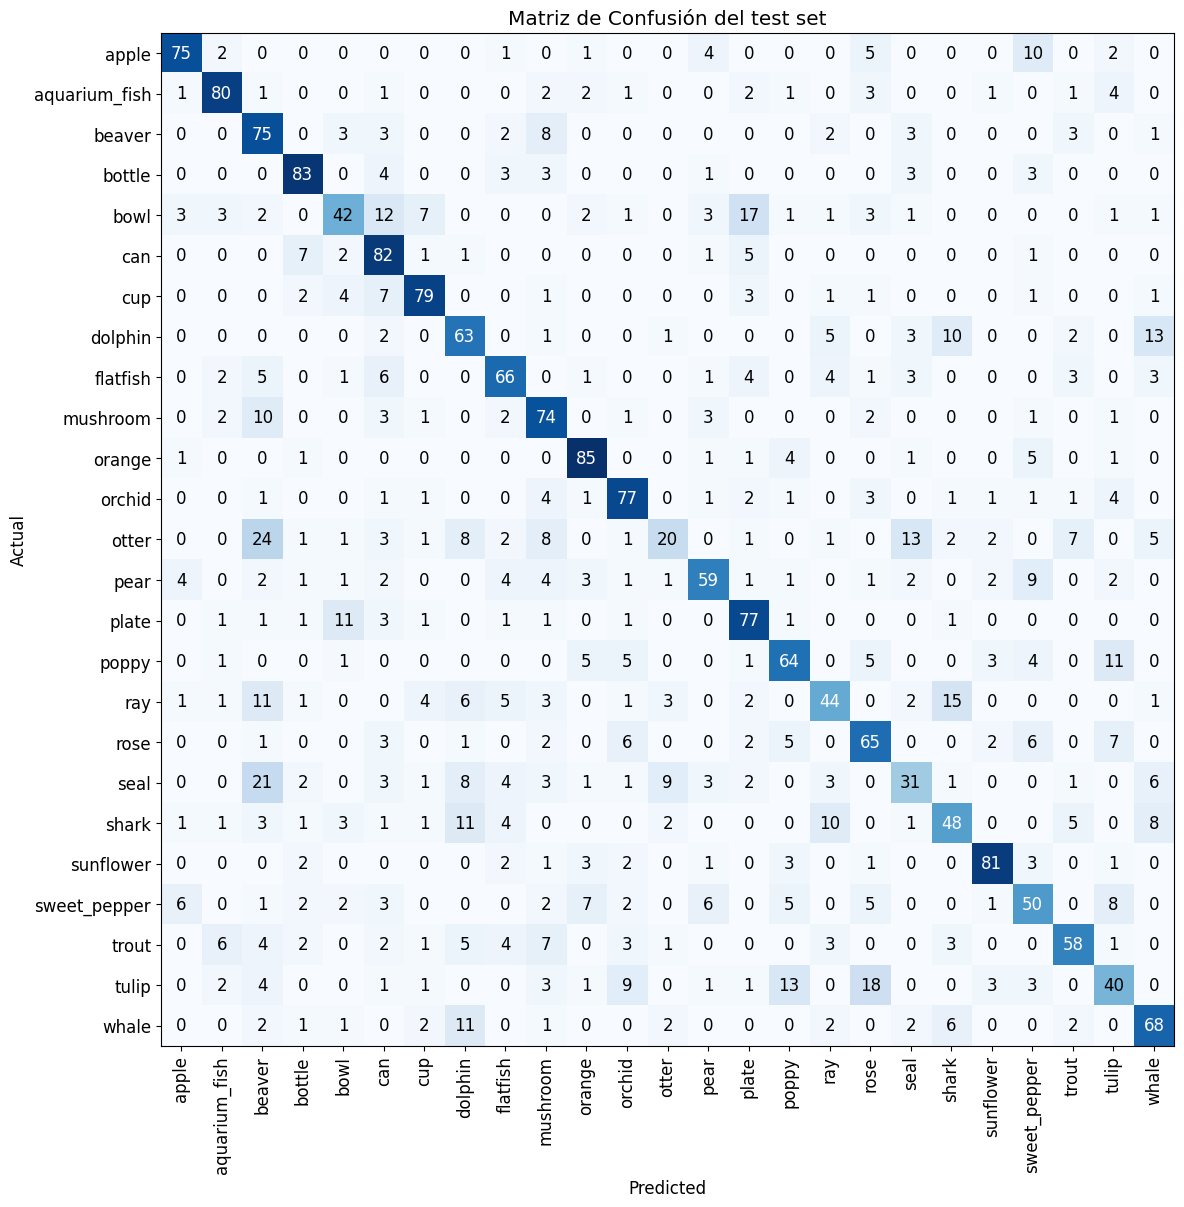

In [ ]:
interp = ClassificationInterpretation.from_learner(learn, 1, test_dl)
cm = interp.confusion_matrix()

print('Número de ejemplos para test:', np.sum(cm))
interp.plot_confusion_matrix(figsize=(12, 12),title='Matriz de Confusión del test set')

De nuevo, salvo seal y otter las cuales predice bastante peor que el resto, no existe ninguna discriminación flagrante a alguna de las clases a predecir, por lo que el modelo funciona correctamente.